# CAT Receptive field mapping stimulation
Parameters readjusted from the paper. Each block is made of 7000 stimulations of .03 second each, meaning 500s per block, for a total of 10 block, that is 40 minutes. No intermediary black screens on this one so we'll have to time properly the stimulations blocks from the photodiode

# So all the parameters are from the papers except the stimulation time, they use 26ms we use 30 ms to make sure the stim is presented even if a frame would be skipped (60 fps, 10 ms frame, meaning 20 ms is acceptable)

In [1]:
import os
import numpy as np
import MotionClouds as mc
import datetime
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import imageio
import warnings
from psychopy import visual, core, event
import MotionClouds as MC
import itertools

downscale = 1
fx, fy, ft = mc.get_grids(mc.N_X//downscale, mc.N_Y//downscale, mc.N_frame//downscale)

now = datetime.datetime.now()
strtime = now.strftime("%Y-%m-%d_%H:%M:%S")   

mc.figpath = os.path.join('sequences/MC_psychopy_%s'% strtime)
if not(os.path.isdir(mc.figpath)): os.mkdir(mc.figpath)

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


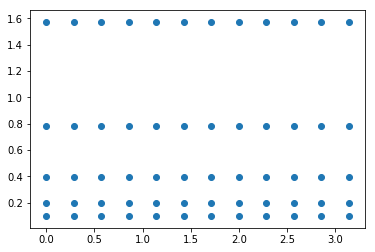

In [2]:
# Orientations
N_thetas = 12
thetas = np.linspace(0,np.pi, N_thetas) # we offset by pi/2 to prevent problems with matplotlib's displays and psychopy

# Noise
B_thetas = [np.pi/32, np.pi/16, np.pi/8, np.pi/4, np.pi/2] 

# Presentation of each pattern
stim_duration = 2 #s

# Repetition of each block
repetition = 15

rng = np.random.RandomState(42)
sequence = list(itertools.product(thetas, B_thetas))
rng.shuffle(sequence)

plt.scatter(*zip(*sequence))

In [3]:
print('This protocolsetup lasts for approx. [%s] minutes (not counting blanks and inter-block screens)' % (N_thetas*len(B_thetas)*stim_duration*repetition/60))
print('Each of the [%s] block lasts for [%s]s' % (repetition, stim_duration*len(sequence)))
print('using [%s] thetas and [%s] b_thetas' % (N_thetas, len(B_thetas)))
print('and presenting each pattern for [%s]s' % stim_duration)

This protocolsetup lasts for approx. [30.0] minutes (not counting blanks and inter-block screens)
Each of the [15] block lasts for [120]s
using [12] thetas and [5] b_thetas
and presenting each pattern for [2]s


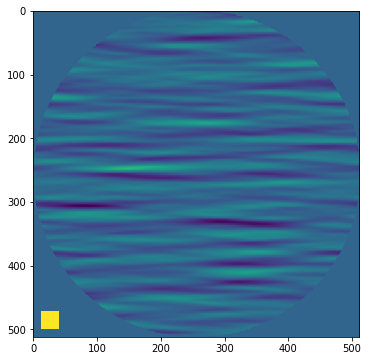

In [4]:
import imageio.core.util

def silence_imageio_warning(*args, **kwargs):
    pass

imageio.core.util._precision_warn = silence_imageio_warning

def get_keypress():
    keys = event.getKeys()
    if keys:
        return keys[0]
    else:
        return None

def generate_cloud(theta, b_theta, itr,
                   N_X, N_Y, seed, contrast=1.,
                  transition = False, save = True):
    
    fx, fy, ft = mc.get_grids(N_X, N_Y, 1)
    disk = mc.frequency_radius(fx, fy, ft) < .5

    mc_i = mc.envelope_gabor(fx, fy, ft,
                             V_X=0., V_Y=0., B_V=0.,
                             sf_0=sf_0, B_sf=B_sf,
                             theta=theta, B_theta=b_theta)

    im_ = np.zeros((N_X, N_Y,1))
    im_ += mc.rectif(mc.random_cloud(mc_i, seed=seed),
                     contrast=contrast)
    im_ *= disk  # masking outside the disk
    im_ += -.5
    im_ += .5*(1-disk)  # gray outside the disk

    if transition : im_[472:500, 12:40] = 1
    else : im_[472:500, 12:40] = -.25

    # data appending
    if save :
        with open(mc.figpath+'/sequence.csv', "a+") as writer_file:
            data_writer = csv.writer(
                writer_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            data_writer.writerow([itr, theta, b_theta, sf_0, B_sf, N_X, N_Y])
            
        imageio.imwrite(mc.figpath+'/%s.png' % itr, im_[:,:,0])

    return im_

width = 29.7*256/1050
N_X, N_Y = 512, 512
sf_0 = 4*width/N_X/2
B_sf = sf_0
im = generate_cloud(sequence[0][0], sequence[0][1], 1, N_X, N_Y, 42, transition = True, save = True)

plt.figure(figsize = (12,6))
plt.imshow(im[:,:,0])

# RF Mapping

In [5]:
now = datetime.datetime.now()
strtime = now.strftime("%Y-%m-%d_%H:%M:%S")   

figpath = os.path.join('sequences/CAT_RFMapping_psychopy_%s'% strtime)
if not(os.path.isdir(figpath)): os.mkdir(figpath)

def homemade_kronecker(arr, n):
    '''
    Homemade kronecker product of two arrays, used here to upscale the simulus
    It's 12 µs faster than numpy's, which is significant given how many kron product
    we'll have to do
    '''
    
    kr = np.repeat(arr, n* np.ones(arr.shape[0], np.int), axis = 0)
    kr = np.repeat(kr, n* np.ones(arr.shape[0], np.int), axis = 1)
    
    return kr

# Initializing PsychoPy window
win = visual.Window(fullscr=True, color=[-1,-1,-1], winType='pygame', monitor='testMonitor', units='height')
mouse = event.Mouse(visible=False)

MC_temp = generate_cloud(theta = np.pi/2, b_theta=np.pi/2, contrast = 1, 
                        N_X = N_X, N_Y = N_Y, seed = 42, transition = False, itr = 0,save = False)
bitmap1 = visual.ImageStim(win, MC_temp, size=1, units='height', flipVert = True)
bitmap1.autolog = False

bitmap3 = visual.ImageStim(win, MC_temp, size=1, units='height')
bitmap3.autolog = False
bitmap3.setImage(np.full((512,512), -1))

blocks = 10 #repeat of same stimulations to increase statistical power
total_stimulations = 7000 # total stimulations per block
presentation_time = .03

for block in range(blocks) :
    for stimulations in range(total_stimulations):
        
        np.random.seed(stimulations) #the seed is set to the stim number, so as to get repeats
        Z = np.random.rand(51,51)
        G = np.zeros((51,51))

        G[Z>0.66] = 1
        G[Z<0.33] = -1
        G[np.bitwise_and(Z>0.33, Z<0.66)] = 0

        #RDA = homemade_kronecker(G, 1)
        RDA = G
        if block == 0 : #since images are the same for all block we only save the first block
            imageio.imwrite(figpath+'/%s.png' % stimulations, RDA)

        #Waiting 5s at the beginning of mapping
        
        if stimulations  == 0 and block == 0 :
            clock0 = core.Clock()
            print('Beginning new RF mapping, drawing blackscreen.')
            while clock0.getTime() < 5 :
                bitmap3.draw()
                win.flip()    

        clock = core.Clock()
        print('Map no.', stimulations)

        bitmap1.setImage(RDA)
        
        #early terminator
        key = get_keypress()
        if key == 'escape' : 
            win.close()
            core.quit()

        #timing one presentation, it works perfectly fine
        while clock.getTime() < presentation_time:
            if clock.getTime() < stim_duration:  # fixation
                bitmap1.draw()
            win.flip()       

win.close()

Beginning new RF mapping, drawing blackscreen.
Map no. 0
Map no. 1
Map no. 2
Map no. 3
Map no. 4
Map no. 5
Map no. 6
Map no. 7
Map no. 8
Map no. 9
Map no. 10
Map no. 11
Map no. 12
Map no. 13
Map no. 14
Map no. 15
Map no. 16
Map no. 17
Map no. 18
Map no. 19
Map no. 20
Map no. 21
Map no. 22
Map no. 23
Map no. 24
Map no. 25
Map no. 26
Map no. 27
Map no. 28
Map no. 29
Map no. 30
Map no. 31
Map no. 32
Map no. 33
Map no. 34
Map no. 35
Map no. 36
Map no. 37
Map no. 38
Map no. 39
Map no. 40
Map no. 41
Map no. 42
Map no. 43
Map no. 44
Map no. 45
Map no. 46
Map no. 47
Map no. 48
Map no. 49
Map no. 50
Map no. 51
Map no. 52
Map no. 53
Map no. 54
Map no. 55
Map no. 56
Map no. 57
Map no. 58
Map no. 59
Map no. 60
Map no. 61
Map no. 62
Map no. 63
Map no. 64
Map no. 65
Map no. 66
Map no. 67
Map no. 68
Map no. 69
Map no. 70
Map no. 71
Map no. 72
Map no. 73
Map no. 74
Map no. 75
Map no. 76
Map no. 77
Map no. 78
Map no. 79
Map no. 80
Map no. 81
Map no. 82
Map no. 83
Map no. 84
Map no. 85
Map no. 86
Map no

Map no. 691
Map no. 692
Map no. 693
Map no. 694
Map no. 695
Map no. 696
Map no. 697
Map no. 698
Map no. 699
Map no. 700
Map no. 701
Map no. 702
Map no. 703
Map no. 704
Map no. 705
Map no. 706
Map no. 707
Map no. 708
Map no. 709
Map no. 710
Map no. 711
Map no. 712
Map no. 713
Map no. 714
Map no. 715
Map no. 716
Map no. 717
Map no. 718
Map no. 719
Map no. 720
Map no. 721
Map no. 722
Map no. 723
Map no. 724
Map no. 725
Map no. 726
Map no. 727
Map no. 728
Map no. 729
Map no. 730
Map no. 731
Map no. 732
Map no. 733
Map no. 734
Map no. 735
Map no. 736
Map no. 737
Map no. 738
Map no. 739
Map no. 740
Map no. 741
Map no. 742
Map no. 743
Map no. 744
Map no. 745
Map no. 746
Map no. 747
Map no. 748
Map no. 749
Map no. 750
Map no. 751
Map no. 752
Map no. 753
Map no. 754
Map no. 755
Map no. 756
Map no. 757
Map no. 758
Map no. 759
Map no. 760
Map no. 761
Map no. 762
Map no. 763
Map no. 764
Map no. 765
Map no. 766
Map no. 767
Map no. 768
Map no. 769
Map no. 770
Map no. 771
Map no. 772
Map no. 773
Map 

Map no. 1351
Map no. 1352
Map no. 1353
Map no. 1354
Map no. 1355
Map no. 1356
Map no. 1357
Map no. 1358
Map no. 1359
Map no. 1360
Map no. 1361
Map no. 1362
Map no. 1363
Map no. 1364
Map no. 1365
Map no. 1366
Map no. 1367
Map no. 1368
Map no. 1369
Map no. 1370
Map no. 1371
Map no. 1372
Map no. 1373
Map no. 1374
Map no. 1375
Map no. 1376
Map no. 1377
Map no. 1378
Map no. 1379
Map no. 1380
Map no. 1381
Map no. 1382
Map no. 1383
Map no. 1384
Map no. 1385
Map no. 1386
Map no. 1387
Map no. 1388
Map no. 1389
Map no. 1390
Map no. 1391
Map no. 1392
Map no. 1393
Map no. 1394
Map no. 1395
Map no. 1396
Map no. 1397
Map no. 1398
Map no. 1399
Map no. 1400
Map no. 1401
Map no. 1402
Map no. 1403
Map no. 1404
Map no. 1405
Map no. 1406
Map no. 1407
Map no. 1408
Map no. 1409
Map no. 1410
Map no. 1411
Map no. 1412
Map no. 1413
Map no. 1414
Map no. 1415
Map no. 1416
Map no. 1417
Map no. 1418
Map no. 1419
Map no. 1420
Map no. 1421
Map no. 1422
Map no. 1423
Map no. 1424
Map no. 1425
Map no. 1426
Map no. 1427

Map no. 1988
Map no. 1989
Map no. 1990
Map no. 1991
Map no. 1992
Map no. 1993
Map no. 1994
Map no. 1995
Map no. 1996
Map no. 1997
Map no. 1998
Map no. 1999
Map no. 2000
Map no. 2001
Map no. 2002
Map no. 2003
Map no. 2004
Map no. 2005
Map no. 2006
Map no. 2007
Map no. 2008
Map no. 2009
Map no. 2010
Map no. 2011
Map no. 2012
Map no. 2013
Map no. 2014
Map no. 2015
Map no. 2016
Map no. 2017
Map no. 2018
Map no. 2019
Map no. 2020
Map no. 2021
Map no. 2022
Map no. 2023
Map no. 2024
Map no. 2025
Map no. 2026
Map no. 2027
Map no. 2028
Map no. 2029
Map no. 2030
Map no. 2031
Map no. 2032
Map no. 2033
Map no. 2034
Map no. 2035
Map no. 2036
Map no. 2037
Map no. 2038
Map no. 2039
Map no. 2040
Map no. 2041
Map no. 2042
Map no. 2043
Map no. 2044
Map no. 2045
Map no. 2046
Map no. 2047
Map no. 2048
Map no. 2049
Map no. 2050
Map no. 2051
Map no. 2052
Map no. 2053
Map no. 2054
Map no. 2055
Map no. 2056
Map no. 2057
Map no. 2058
Map no. 2059
Map no. 2060
Map no. 2061
Map no. 2062
Map no. 2063
Map no. 2064

Map no. 2622
Map no. 2623
Map no. 2624
Map no. 2625
Map no. 2626
Map no. 2627
Map no. 2628
Map no. 2629
Map no. 2630
Map no. 2631
Map no. 2632
Map no. 2633
Map no. 2634
Map no. 2635
Map no. 2636
Map no. 2637
Map no. 2638
Map no. 2639
Map no. 2640
Map no. 2641
Map no. 2642
Map no. 2643
Map no. 2644
Map no. 2645
Map no. 2646
Map no. 2647
Map no. 2648
Map no. 2649
Map no. 2650
Map no. 2651
Map no. 2652
Map no. 2653
Map no. 2654
Map no. 2655
Map no. 2656
Map no. 2657
Map no. 2658
Map no. 2659
Map no. 2660
Map no. 2661
Map no. 2662
Map no. 2663
Map no. 2664
Map no. 2665
Map no. 2666
Map no. 2667
Map no. 2668
Map no. 2669
Map no. 2670
Map no. 2671
Map no. 2672
Map no. 2673
Map no. 2674
Map no. 2675
Map no. 2676
Map no. 2677
Map no. 2678
Map no. 2679
Map no. 2680
Map no. 2681
Map no. 2682
Map no. 2683
Map no. 2684
Map no. 2685
Map no. 2686
Map no. 2687
Map no. 2688
Map no. 2689
Map no. 2690
Map no. 2691
Map no. 2692
Map no. 2693
Map no. 2694
Map no. 2695
Map no. 2696
Map no. 2697
Map no. 2698

Map no. 3259
Map no. 3260
Map no. 3261
Map no. 3262
Map no. 3263
Map no. 3264
Map no. 3265
Map no. 3266
Map no. 3267
Map no. 3268
Map no. 3269
Map no. 3270
Map no. 3271
Map no. 3272
Map no. 3273
Map no. 3274
Map no. 3275
Map no. 3276
Map no. 3277
Map no. 3278
Map no. 3279
Map no. 3280
Map no. 3281
Map no. 3282
Map no. 3283
Map no. 3284
Map no. 3285
Map no. 3286
Map no. 3287
Map no. 3288
Map no. 3289
Map no. 3290
Map no. 3291
Map no. 3292
Map no. 3293
Map no. 3294
Map no. 3295
Map no. 3296
Map no. 3297
Map no. 3298
Map no. 3299
Map no. 3300
Map no. 3301
Map no. 3302
Map no. 3303
Map no. 3304
Map no. 3305
Map no. 3306
Map no. 3307
Map no. 3308
Map no. 3309
Map no. 3310
Map no. 3311
Map no. 3312
Map no. 3313
Map no. 3314
Map no. 3315
Map no. 3316
Map no. 3317
Map no. 3318
Map no. 3319
Map no. 3320
Map no. 3321
Map no. 3322
Map no. 3323
Map no. 3324
Map no. 3325
Map no. 3326
Map no. 3327
Map no. 3328
Map no. 3329
Map no. 3330
Map no. 3331
Map no. 3332
Map no. 3333
Map no. 3334
Map no. 3335

Map no. 3893
Map no. 3894
Map no. 3895
Map no. 3896
Map no. 3897
Map no. 3898
Map no. 3899
Map no. 3900
Map no. 3901
Map no. 3902
Map no. 3903
Map no. 3904
Map no. 3905
Map no. 3906
Map no. 3907
Map no. 3908
Map no. 3909
Map no. 3910
Map no. 3911
Map no. 3912
Map no. 3913
Map no. 3914
Map no. 3915
Map no. 3916
Map no. 3917
Map no. 3918
Map no. 3919
Map no. 3920
Map no. 3921
Map no. 3922
Map no. 3923
Map no. 3924
Map no. 3925
Map no. 3926
Map no. 3927
Map no. 3928
Map no. 3929
Map no. 3930
Map no. 3931
Map no. 3932
Map no. 3933
Map no. 3934
Map no. 3935
Map no. 3936
Map no. 3937
Map no. 3938
Map no. 3939
Map no. 3940
Map no. 3941
Map no. 3942
Map no. 3943
Map no. 3944
Map no. 3945
Map no. 3946
Map no. 3947
Map no. 3948
Map no. 3949
Map no. 3950
Map no. 3951
Map no. 3952
Map no. 3953
Map no. 3954
Map no. 3955
Map no. 3956
Map no. 3957
Map no. 3958
Map no. 3959
Map no. 3960
Map no. 3961
Map no. 3962
Map no. 3963
Map no. 3964
Map no. 3965
Map no. 3966
Map no. 3967
Map no. 3968
Map no. 3969

Map no. 4530
Map no. 4531
Map no. 4532
Map no. 4533
Map no. 4534
Map no. 4535
Map no. 4536
Map no. 4537
Map no. 4538
Map no. 4539
Map no. 4540
Map no. 4541
Map no. 4542
Map no. 4543
Map no. 4544
Map no. 4545
Map no. 4546
Map no. 4547
Map no. 4548
Map no. 4549
Map no. 4550
Map no. 4551
Map no. 4552
Map no. 4553
Map no. 4554
Map no. 4555
Map no. 4556
Map no. 4557
Map no. 4558
Map no. 4559
Map no. 4560
Map no. 4561
Map no. 4562
Map no. 4563
Map no. 4564
Map no. 4565
Map no. 4566
Map no. 4567
Map no. 4568
Map no. 4569
Map no. 4570
Map no. 4571
Map no. 4572
Map no. 4573
Map no. 4574
Map no. 4575
Map no. 4576
Map no. 4577
Map no. 4578
Map no. 4579
Map no. 4580
Map no. 4581
Map no. 4582
Map no. 4583
Map no. 4584
Map no. 4585
Map no. 4586
Map no. 4587
Map no. 4588
Map no. 4589
Map no. 4590
Map no. 4591
Map no. 4592
Map no. 4593
Map no. 4594
Map no. 4595
Map no. 4596
Map no. 4597
Map no. 4598
Map no. 4599
Map no. 4600
Map no. 4601
Map no. 4602
Map no. 4603
Map no. 4604
Map no. 4605
Map no. 4606

Map no. 5167
Map no. 5168
Map no. 5169
Map no. 5170
Map no. 5171
Map no. 5172
Map no. 5173
Map no. 5174
Map no. 5175
Map no. 5176
Map no. 5177
Map no. 5178
Map no. 5179
Map no. 5180
Map no. 5181
Map no. 5182
Map no. 5183
Map no. 5184
Map no. 5185
Map no. 5186
Map no. 5187
Map no. 5188
Map no. 5189
Map no. 5190
Map no. 5191
Map no. 5192
Map no. 5193
Map no. 5194
Map no. 5195
Map no. 5196
Map no. 5197
Map no. 5198
Map no. 5199
Map no. 5200
Map no. 5201
Map no. 5202
Map no. 5203
Map no. 5204
Map no. 5205
Map no. 5206
Map no. 5207
Map no. 5208
Map no. 5209
Map no. 5210
Map no. 5211
Map no. 5212
Map no. 5213
Map no. 5214
Map no. 5215
Map no. 5216
Map no. 5217
Map no. 5218
Map no. 5219
Map no. 5220
Map no. 5221
Map no. 5222
Map no. 5223
Map no. 5224
Map no. 5225
Map no. 5226
Map no. 5227
Map no. 5228
Map no. 5229
Map no. 5230
Map no. 5231
Map no. 5232
Map no. 5233
Map no. 5234
Map no. 5235
Map no. 5236
Map no. 5237
Map no. 5238
Map no. 5239
Map no. 5240
Map no. 5241
Map no. 5242
Map no. 5243

Map no. 5803
Map no. 5804
Map no. 5805
Map no. 5806
Map no. 5807
Map no. 5808
Map no. 5809
Map no. 5810
Map no. 5811
Map no. 5812
Map no. 5813
Map no. 5814
Map no. 5815
Map no. 5816
Map no. 5817
Map no. 5818
Map no. 5819
Map no. 5820
Map no. 5821
Map no. 5822
Map no. 5823
Map no. 5824
Map no. 5825
Map no. 5826
Map no. 5827
Map no. 5828
Map no. 5829
Map no. 5830
Map no. 5831
Map no. 5832
Map no. 5833
Map no. 5834
Map no. 5835
Map no. 5836
Map no. 5837
Map no. 5838
Map no. 5839
Map no. 5840
Map no. 5841
Map no. 5842
Map no. 5843
Map no. 5844
Map no. 5845
Map no. 5846
Map no. 5847
Map no. 5848
Map no. 5849
Map no. 5850
Map no. 5851
Map no. 5852
Map no. 5853
Map no. 5854
Map no. 5855
Map no. 5856
Map no. 5857
Map no. 5858
Map no. 5859
Map no. 5860
Map no. 5861
Map no. 5862
Map no. 5863
Map no. 5864
Map no. 5865
Map no. 5866
Map no. 5867
Map no. 5868
Map no. 5869
Map no. 5870
Map no. 5871
Map no. 5872
Map no. 5873
Map no. 5874
Map no. 5875
Map no. 5876
Map no. 5877
Map no. 5878
Map no. 5879

Map no. 6440
Map no. 6441
Map no. 6442
Map no. 6443
Map no. 6444
Map no. 6445
Map no. 6446
Map no. 6447
Map no. 6448
Map no. 6449
Map no. 6450
Map no. 6451
Map no. 6452
Map no. 6453
Map no. 6454
Map no. 6455
Map no. 6456
Map no. 6457
Map no. 6458
Map no. 6459
Map no. 6460
Map no. 6461
Map no. 6462
Map no. 6463
Map no. 6464
Map no. 6465
Map no. 6466
Map no. 6467
Map no. 6468
Map no. 6469
Map no. 6470
Map no. 6471
Map no. 6472
Map no. 6473
Map no. 6474
Map no. 6475
Map no. 6476
Map no. 6477
Map no. 6478
Map no. 6479
Map no. 6480
Map no. 6481
Map no. 6482
Map no. 6483
Map no. 6484
Map no. 6485
Map no. 6486
Map no. 6487
Map no. 6488
Map no. 6489
Map no. 6490
Map no. 6491
Map no. 6492
Map no. 6493
Map no. 6494
Map no. 6495
Map no. 6496
Map no. 6497
Map no. 6498
Map no. 6499
Map no. 6500
Map no. 6501
Map no. 6502
Map no. 6503
Map no. 6504
Map no. 6505
Map no. 6506
Map no. 6507
Map no. 6508
Map no. 6509
Map no. 6510
Map no. 6511
Map no. 6512
Map no. 6513
Map no. 6514
Map no. 6515
Map no. 6516

Map no. 87
Map no. 88
Map no. 89
Map no. 90
Map no. 91
Map no. 92
Map no. 93
Map no. 94
Map no. 95
Map no. 96
Map no. 97
Map no. 98
Map no. 99
Map no. 100
Map no. 101
Map no. 102
Map no. 103
Map no. 104
Map no. 105
Map no. 106
Map no. 107
Map no. 108
Map no. 109
Map no. 110
Map no. 111
Map no. 112
Map no. 113
Map no. 114
Map no. 115
Map no. 116
Map no. 117
Map no. 118
Map no. 119
Map no. 120
Map no. 121
Map no. 122
Map no. 123
Map no. 124
Map no. 125
Map no. 126
Map no. 127
Map no. 128
Map no. 129
Map no. 130
Map no. 131
Map no. 132
Map no. 133
Map no. 134
Map no. 135
Map no. 136
Map no. 137
Map no. 138
Map no. 139
Map no. 140
Map no. 141
Map no. 142
Map no. 143
Map no. 144
Map no. 145
Map no. 146
Map no. 147
Map no. 148
Map no. 149
Map no. 150
Map no. 151
Map no. 152
Map no. 153
Map no. 154
Map no. 155
Map no. 156
Map no. 157
Map no. 158
Map no. 159
Map no. 160
Map no. 161
Map no. 162
Map no. 163
Map no. 164
Map no. 165
Map no. 166
Map no. 167
Map no. 168
Map no. 169
Map no. 170
Map n

Map no. 773
Map no. 774
Map no. 775
Map no. 776
Map no. 777
Map no. 778
Map no. 779
Map no. 780
Map no. 781
Map no. 782
Map no. 783
Map no. 784
Map no. 785
Map no. 786
Map no. 787
Map no. 788
Map no. 789
Map no. 790
Map no. 791
Map no. 792
Map no. 793
Map no. 794
Map no. 795
Map no. 796
Map no. 797
Map no. 798
Map no. 799
Map no. 800
Map no. 801
Map no. 802
Map no. 803
Map no. 804
Map no. 805
Map no. 806
Map no. 807
Map no. 808
Map no. 809
Map no. 810
Map no. 811
Map no. 812
Map no. 813
Map no. 814
Map no. 815
Map no. 816
Map no. 817
Map no. 818
Map no. 819
Map no. 820
Map no. 821
Map no. 822
Map no. 823
Map no. 824
Map no. 825
Map no. 826
Map no. 827
Map no. 828
Map no. 829
Map no. 830
Map no. 831
Map no. 832
Map no. 833
Map no. 834
Map no. 835
Map no. 836
Map no. 837
Map no. 838
Map no. 839
Map no. 840
Map no. 841
Map no. 842
Map no. 843
Map no. 844
Map no. 845
Map no. 846
Map no. 847
Map no. 848
Map no. 849
Map no. 850
Map no. 851
Map no. 852
Map no. 853
Map no. 854
Map no. 855
Map 

Map no. 1423
Map no. 1424
Map no. 1425
Map no. 1426
Map no. 1427
Map no. 1428
Map no. 1429
Map no. 1430
Map no. 1431
Map no. 1432
Map no. 1433
Map no. 1434
Map no. 1435
Map no. 1436
Map no. 1437
Map no. 1438
Map no. 1439
Map no. 1440
Map no. 1441
Map no. 1442
Map no. 1443
Map no. 1444
Map no. 1445
Map no. 1446
Map no. 1447
Map no. 1448
Map no. 1449
Map no. 1450
Map no. 1451
Map no. 1452
Map no. 1453
Map no. 1454
Map no. 1455
Map no. 1456
Map no. 1457
Map no. 1458
Map no. 1459
Map no. 1460
Map no. 1461
Map no. 1462
Map no. 1463
Map no. 1464
Map no. 1465
Map no. 1466
Map no. 1467
Map no. 1468
Map no. 1469
Map no. 1470
Map no. 1471
Map no. 1472
Map no. 1473
Map no. 1474
Map no. 1475
Map no. 1476
Map no. 1477
Map no. 1478
Map no. 1479
Map no. 1480
Map no. 1481
Map no. 1482
Map no. 1483
Map no. 1484
Map no. 1485
Map no. 1486
Map no. 1487
Map no. 1488
Map no. 1489
Map no. 1490
Map no. 1491
Map no. 1492
Map no. 1493
Map no. 1494
Map no. 1495
Map no. 1496
Map no. 1497
Map no. 1498
Map no. 1499

Map no. 2060
Map no. 2061
Map no. 2062
Map no. 2063
Map no. 2064
Map no. 2065
Map no. 2066
Map no. 2067
Map no. 2068
Map no. 2069
Map no. 2070
Map no. 2071
Map no. 2072
Map no. 2073
Map no. 2074
Map no. 2075
Map no. 2076
Map no. 2077
Map no. 2078
Map no. 2079
Map no. 2080
Map no. 2081
Map no. 2082
Map no. 2083
Map no. 2084
Map no. 2085
Map no. 2086
Map no. 2087
Map no. 2088
Map no. 2089
Map no. 2090
Map no. 2091
Map no. 2092
Map no. 2093
Map no. 2094
Map no. 2095
Map no. 2096
Map no. 2097
Map no. 2098
Map no. 2099
Map no. 2100
Map no. 2101
Map no. 2102
Map no. 2103
Map no. 2104
Map no. 2105
Map no. 2106
Map no. 2107
Map no. 2108
Map no. 2109
Map no. 2110
Map no. 2111
Map no. 2112
Map no. 2113
Map no. 2114
Map no. 2115
Map no. 2116
Map no. 2117
Map no. 2118
Map no. 2119
Map no. 2120
Map no. 2121
Map no. 2122
Map no. 2123
Map no. 2124
Map no. 2125
Map no. 2126
Map no. 2127
Map no. 2128
Map no. 2129
Map no. 2130
Map no. 2131
Map no. 2132
Map no. 2133
Map no. 2134
Map no. 2135
Map no. 2136

Map no. 2695
Map no. 2696
Map no. 2697
Map no. 2698
Map no. 2699
Map no. 2700
Map no. 2701
Map no. 2702
Map no. 2703
Map no. 2704
Map no. 2705
Map no. 2706
Map no. 2707
Map no. 2708
Map no. 2709
Map no. 2710
Map no. 2711
Map no. 2712
Map no. 2713
Map no. 2714
Map no. 2715
Map no. 2716
Map no. 2717
Map no. 2718
Map no. 2719
Map no. 2720
Map no. 2721
Map no. 2722
Map no. 2723
Map no. 2724
Map no. 2725
Map no. 2726
Map no. 2727
Map no. 2728
Map no. 2729
Map no. 2730
Map no. 2731
Map no. 2732
Map no. 2733
Map no. 2734
Map no. 2735
Map no. 2736
Map no. 2737
Map no. 2738
Map no. 2739
Map no. 2740
Map no. 2741
Map no. 2742
Map no. 2743
Map no. 2744
Map no. 2745
Map no. 2746
Map no. 2747
Map no. 2748
Map no. 2749
Map no. 2750
Map no. 2751
Map no. 2752
Map no. 2753
Map no. 2754
Map no. 2755
Map no. 2756
Map no. 2757
Map no. 2758
Map no. 2759
Map no. 2760
Map no. 2761
Map no. 2762
Map no. 2763
Map no. 2764
Map no. 2765
Map no. 2766
Map no. 2767
Map no. 2768
Map no. 2769
Map no. 2770
Map no. 2771

Map no. 3332
Map no. 3333
Map no. 3334
Map no. 3335
Map no. 3336
Map no. 3337
Map no. 3338
Map no. 3339
Map no. 3340
Map no. 3341
Map no. 3342
Map no. 3343
Map no. 3344
Map no. 3345
Map no. 3346
Map no. 3347
Map no. 3348
Map no. 3349
Map no. 3350
Map no. 3351
Map no. 3352
Map no. 3353
Map no. 3354
Map no. 3355
Map no. 3356
Map no. 3357
Map no. 3358
Map no. 3359
Map no. 3360
Map no. 3361
Map no. 3362
Map no. 3363
Map no. 3364
Map no. 3365
Map no. 3366
Map no. 3367
Map no. 3368
Map no. 3369
Map no. 3370
Map no. 3371
Map no. 3372
Map no. 3373
Map no. 3374
Map no. 3375
Map no. 3376
Map no. 3377
Map no. 3378
Map no. 3379
Map no. 3380
Map no. 3381
Map no. 3382
Map no. 3383
Map no. 3384
Map no. 3385
Map no. 3386
Map no. 3387
Map no. 3388
Map no. 3389
Map no. 3390
Map no. 3391
Map no. 3392
Map no. 3393
Map no. 3394
Map no. 3395
Map no. 3396
Map no. 3397
Map no. 3398
Map no. 3399
Map no. 3400
Map no. 3401
Map no. 3402
Map no. 3403
Map no. 3404
Map no. 3405
Map no. 3406
Map no. 3407
Map no. 3408

Map no. 3968
Map no. 3969
Map no. 3970
Map no. 3971
Map no. 3972
Map no. 3973
Map no. 3974
Map no. 3975
Map no. 3976
Map no. 3977
Map no. 3978
Map no. 3979
Map no. 3980
Map no. 3981
Map no. 3982
Map no. 3983
Map no. 3984
Map no. 3985
Map no. 3986
Map no. 3987
Map no. 3988
Map no. 3989
Map no. 3990
Map no. 3991
Map no. 3992
Map no. 3993
Map no. 3994
Map no. 3995
Map no. 3996
Map no. 3997
Map no. 3998
Map no. 3999
Map no. 4000
Map no. 4001
Map no. 4002
Map no. 4003
Map no. 4004
Map no. 4005
Map no. 4006
Map no. 4007
Map no. 4008
Map no. 4009
Map no. 4010
Map no. 4011
Map no. 4012
Map no. 4013
Map no. 4014
Map no. 4015
Map no. 4016
Map no. 4017
Map no. 4018
Map no. 4019
Map no. 4020
Map no. 4021
Map no. 4022
Map no. 4023
Map no. 4024
Map no. 4025
Map no. 4026
Map no. 4027
Map no. 4028
Map no. 4029
Map no. 4030
Map no. 4031
Map no. 4032
Map no. 4033
Map no. 4034
Map no. 4035
Map no. 4036
Map no. 4037
Map no. 4038
Map no. 4039
Map no. 4040
Map no. 4041
Map no. 4042
Map no. 4043
Map no. 4044

Map no. 4602
Map no. 4603
Map no. 4604
Map no. 4605
Map no. 4606
Map no. 4607
Map no. 4608
Map no. 4609
Map no. 4610
Map no. 4611
Map no. 4612
Map no. 4613
Map no. 4614
Map no. 4615
Map no. 4616
Map no. 4617
Map no. 4618
Map no. 4619
Map no. 4620
Map no. 4621
Map no. 4622
Map no. 4623
Map no. 4624
Map no. 4625
Map no. 4626
Map no. 4627
Map no. 4628
Map no. 4629
Map no. 4630
Map no. 4631
Map no. 4632
Map no. 4633
Map no. 4634
Map no. 4635
Map no. 4636
Map no. 4637
Map no. 4638
Map no. 4639
Map no. 4640
Map no. 4641
Map no. 4642
Map no. 4643
Map no. 4644
Map no. 4645
Map no. 4646
Map no. 4647
Map no. 4648
Map no. 4649
Map no. 4650
Map no. 4651
Map no. 4652
Map no. 4653
Map no. 4654
Map no. 4655
Map no. 4656
Map no. 4657
Map no. 4658
Map no. 4659
Map no. 4660
Map no. 4661
Map no. 4662
Map no. 4663
Map no. 4664
Map no. 4665
Map no. 4666
Map no. 4667
Map no. 4668
Map no. 4669
Map no. 4670
Map no. 4671
Map no. 4672
Map no. 4673
Map no. 4674
Map no. 4675
Map no. 4676
Map no. 4677
Map no. 4678

Map no. 5239
Map no. 5240
Map no. 5241
Map no. 5242
Map no. 5243
Map no. 5244
Map no. 5245
Map no. 5246
Map no. 5247
Map no. 5248
Map no. 5249
Map no. 5250
Map no. 5251
Map no. 5252
Map no. 5253
Map no. 5254
Map no. 5255
Map no. 5256
Map no. 5257
Map no. 5258
Map no. 5259
Map no. 5260
Map no. 5261
Map no. 5262
Map no. 5263
Map no. 5264
Map no. 5265
Map no. 5266
Map no. 5267
Map no. 5268
Map no. 5269
Map no. 5270
Map no. 5271
Map no. 5272
Map no. 5273
Map no. 5274
Map no. 5275
Map no. 5276
Map no. 5277
Map no. 5278
Map no. 5279
Map no. 5280
Map no. 5281
Map no. 5282
Map no. 5283
Map no. 5284
Map no. 5285
Map no. 5286
Map no. 5287
Map no. 5288
Map no. 5289
Map no. 5290
Map no. 5291
Map no. 5292
Map no. 5293
Map no. 5294
Map no. 5295
Map no. 5296
Map no. 5297
Map no. 5298
Map no. 5299
Map no. 5300
Map no. 5301
Map no. 5302
Map no. 5303
Map no. 5304
Map no. 5305
Map no. 5306
Map no. 5307
Map no. 5308
Map no. 5309
Map no. 5310
Map no. 5311
Map no. 5312
Map no. 5313
Map no. 5314
Map no. 5315

Map no. 5874
Map no. 5875
Map no. 5876
Map no. 5877
Map no. 5878
Map no. 5879
Map no. 5880
Map no. 5881
Map no. 5882
Map no. 5883
Map no. 5884
Map no. 5885
Map no. 5886
Map no. 5887
Map no. 5888
Map no. 5889
Map no. 5890
Map no. 5891
Map no. 5892
Map no. 5893
Map no. 5894
Map no. 5895
Map no. 5896
Map no. 5897
Map no. 5898
Map no. 5899
Map no. 5900
Map no. 5901
Map no. 5902
Map no. 5903
Map no. 5904
Map no. 5905
Map no. 5906
Map no. 5907
Map no. 5908
Map no. 5909
Map no. 5910
Map no. 5911
Map no. 5912
Map no. 5913
Map no. 5914
Map no. 5915
Map no. 5916
Map no. 5917
Map no. 5918
Map no. 5919
Map no. 5920
Map no. 5921
Map no. 5922
Map no. 5923
Map no. 5924
Map no. 5925
Map no. 5926
Map no. 5927
Map no. 5928
Map no. 5929
Map no. 5930
Map no. 5931
Map no. 5932
Map no. 5933
Map no. 5934
Map no. 5935
Map no. 5936
Map no. 5937
Map no. 5938
Map no. 5939
Map no. 5940
Map no. 5941
Map no. 5942
Map no. 5943
Map no. 5944
Map no. 5945
Map no. 5946
Map no. 5947
Map no. 5948
Map no. 5949
Map no. 5950

Map no. 6511
Map no. 6512
Map no. 6513
Map no. 6514
Map no. 6515
Map no. 6516
Map no. 6517
Map no. 6518
Map no. 6519
Map no. 6520
Map no. 6521
Map no. 6522
Map no. 6523
Map no. 6524
Map no. 6525
Map no. 6526
Map no. 6527
Map no. 6528
Map no. 6529
Map no. 6530
Map no. 6531
Map no. 6532
Map no. 6533
Map no. 6534
Map no. 6535
Map no. 6536
Map no. 6537
Map no. 6538
Map no. 6539
Map no. 6540
Map no. 6541
Map no. 6542
Map no. 6543
Map no. 6544
Map no. 6545
Map no. 6546
Map no. 6547
Map no. 6548
Map no. 6549
Map no. 6550
Map no. 6551
Map no. 6552
Map no. 6553
Map no. 6554
Map no. 6555
Map no. 6556
Map no. 6557
Map no. 6558
Map no. 6559
Map no. 6560
Map no. 6561
Map no. 6562
Map no. 6563
Map no. 6564
Map no. 6565
Map no. 6566
Map no. 6567
Map no. 6568
Map no. 6569
Map no. 6570
Map no. 6571
Map no. 6572
Map no. 6573
Map no. 6574
Map no. 6575
Map no. 6576
Map no. 6577
Map no. 6578
Map no. 6579
Map no. 6580
Map no. 6581
Map no. 6582
Map no. 6583
Map no. 6584
Map no. 6585
Map no. 6586
Map no. 6587

Map no. 167
Map no. 168
Map no. 169
Map no. 170
Map no. 171
Map no. 172
Map no. 173
Map no. 174
Map no. 175
Map no. 176
Map no. 177
Map no. 178
Map no. 179
Map no. 180
Map no. 181
Map no. 182
Map no. 183
Map no. 184
Map no. 185
Map no. 186
Map no. 187
Map no. 188
Map no. 189
Map no. 190
Map no. 191
Map no. 192
Map no. 193
Map no. 194
Map no. 195
Map no. 196
Map no. 197
Map no. 198
Map no. 199
Map no. 200
Map no. 201
Map no. 202
Map no. 203
Map no. 204
Map no. 205
Map no. 206
Map no. 207
Map no. 208
Map no. 209
Map no. 210
Map no. 211
Map no. 212
Map no. 213
Map no. 214
Map no. 215
Map no. 216
Map no. 217
Map no. 218
Map no. 219
Map no. 220
Map no. 221
Map no. 222
Map no. 223
Map no. 224
Map no. 225
Map no. 226
Map no. 227
Map no. 228
Map no. 229
Map no. 230
Map no. 231
Map no. 232
Map no. 233
Map no. 234
Map no. 235
Map no. 236
Map no. 237
Map no. 238
Map no. 239
Map no. 240
Map no. 241
Map no. 242
Map no. 243
Map no. 244
Map no. 245
Map no. 246
Map no. 247
Map no. 248
Map no. 249
Map 

Map no. 853
Map no. 854
Map no. 855
Map no. 856
Map no. 857
Map no. 858
Map no. 859
Map no. 860
Map no. 861
Map no. 862
Map no. 863
Map no. 864
Map no. 865
Map no. 866
Map no. 867
Map no. 868
Map no. 869
Map no. 870
Map no. 871
Map no. 872
Map no. 873
Map no. 874
Map no. 875
Map no. 876
Map no. 877
Map no. 878
Map no. 879
Map no. 880
Map no. 881
Map no. 882
Map no. 883
Map no. 884
Map no. 885
Map no. 886
Map no. 887
Map no. 888
Map no. 889
Map no. 890
Map no. 891
Map no. 892
Map no. 893
Map no. 894
Map no. 895
Map no. 896
Map no. 897
Map no. 898
Map no. 899
Map no. 900
Map no. 901
Map no. 902
Map no. 903
Map no. 904
Map no. 905
Map no. 906
Map no. 907
Map no. 908
Map no. 909
Map no. 910
Map no. 911
Map no. 912
Map no. 913
Map no. 914
Map no. 915
Map no. 916
Map no. 917
Map no. 918
Map no. 919
Map no. 920
Map no. 921
Map no. 922
Map no. 923
Map no. 924
Map no. 925
Map no. 926
Map no. 927
Map no. 928
Map no. 929
Map no. 930
Map no. 931
Map no. 932
Map no. 933
Map no. 934
Map no. 935
Map 

Map no. 1500
Map no. 1501
Map no. 1502
Map no. 1503
Map no. 1504
Map no. 1505
Map no. 1506
Map no. 1507
Map no. 1508
Map no. 1509
Map no. 1510
Map no. 1511
Map no. 1512
Map no. 1513
Map no. 1514
Map no. 1515
Map no. 1516
Map no. 1517
Map no. 1518
Map no. 1519
Map no. 1520
Map no. 1521
Map no. 1522
Map no. 1523
Map no. 1524
Map no. 1525
Map no. 1526
Map no. 1527
Map no. 1528
Map no. 1529
Map no. 1530
Map no. 1531
Map no. 1532
Map no. 1533
Map no. 1534
Map no. 1535
Map no. 1536
Map no. 1537
Map no. 1538
Map no. 1539
Map no. 1540
Map no. 1541
Map no. 1542
Map no. 1543
Map no. 1544
Map no. 1545
Map no. 1546
Map no. 1547
Map no. 1548
Map no. 1549
Map no. 1550
Map no. 1551
Map no. 1552
Map no. 1553
Map no. 1554
Map no. 1555
Map no. 1556
Map no. 1557
Map no. 1558
Map no. 1559
Map no. 1560
Map no. 1561
Map no. 1562
Map no. 1563
Map no. 1564
Map no. 1565
Map no. 1566
Map no. 1567
Map no. 1568
Map no. 1569
Map no. 1570
Map no. 1571
Map no. 1572
Map no. 1573
Map no. 1574
Map no. 1575
Map no. 1576

Map no. 2137
Map no. 2138
Map no. 2139
Map no. 2140
Map no. 2141
Map no. 2142
Map no. 2143
Map no. 2144
Map no. 2145
Map no. 2146
Map no. 2147
Map no. 2148
Map no. 2149
Map no. 2150
Map no. 2151
Map no. 2152
Map no. 2153
Map no. 2154
Map no. 2155
Map no. 2156
Map no. 2157
Map no. 2158
Map no. 2159
Map no. 2160
Map no. 2161
Map no. 2162
Map no. 2163
Map no. 2164
Map no. 2165
Map no. 2166
Map no. 2167
Map no. 2168
Map no. 2169
Map no. 2170
Map no. 2171
Map no. 2172
Map no. 2173
Map no. 2174
Map no. 2175
Map no. 2176
Map no. 2177
Map no. 2178
Map no. 2179
Map no. 2180
Map no. 2181
Map no. 2182
Map no. 2183
Map no. 2184
Map no. 2185
Map no. 2186
Map no. 2187
Map no. 2188
Map no. 2189
Map no. 2190
Map no. 2191
Map no. 2192
Map no. 2193
Map no. 2194
Map no. 2195
Map no. 2196
Map no. 2197
Map no. 2198
Map no. 2199
Map no. 2200
Map no. 2201
Map no. 2202
Map no. 2203
Map no. 2204
Map no. 2205
Map no. 2206
Map no. 2207
Map no. 2208
Map no. 2209
Map no. 2210
Map no. 2211
Map no. 2212
Map no. 2213

Map no. 2774
Map no. 2775
Map no. 2776
Map no. 2777
Map no. 2778
Map no. 2779
Map no. 2780
Map no. 2781
Map no. 2782
Map no. 2783
Map no. 2784
Map no. 2785
Map no. 2786
Map no. 2787
Map no. 2788
Map no. 2789
Map no. 2790
Map no. 2791
Map no. 2792
Map no. 2793
Map no. 2794
Map no. 2795
Map no. 2796
Map no. 2797
Map no. 2798
Map no. 2799
Map no. 2800
Map no. 2801
Map no. 2802
Map no. 2803
Map no. 2804
Map no. 2805
Map no. 2806
Map no. 2807
Map no. 2808
Map no. 2809
Map no. 2810
Map no. 2811
Map no. 2812
Map no. 2813
Map no. 2814
Map no. 2815
Map no. 2816
Map no. 2817
Map no. 2818
Map no. 2819
Map no. 2820
Map no. 2821
Map no. 2822
Map no. 2823
Map no. 2824
Map no. 2825
Map no. 2826
Map no. 2827
Map no. 2828
Map no. 2829
Map no. 2830
Map no. 2831
Map no. 2832
Map no. 2833
Map no. 2834
Map no. 2835
Map no. 2836
Map no. 2837
Map no. 2838
Map no. 2839
Map no. 2840
Map no. 2841
Map no. 2842
Map no. 2843
Map no. 2844
Map no. 2845
Map no. 2846
Map no. 2847
Map no. 2848
Map no. 2849
Map no. 2850

Map no. 3410
Map no. 3411
Map no. 3412
Map no. 3413
Map no. 3414
Map no. 3415
Map no. 3416
Map no. 3417
Map no. 3418
Map no. 3419
Map no. 3420
Map no. 3421
Map no. 3422
Map no. 3423
Map no. 3424
Map no. 3425
Map no. 3426
Map no. 3427
Map no. 3428
Map no. 3429
Map no. 3430
Map no. 3431
Map no. 3432
Map no. 3433
Map no. 3434
Map no. 3435
Map no. 3436
Map no. 3437
Map no. 3438
Map no. 3439
Map no. 3440
Map no. 3441
Map no. 3442
Map no. 3443
Map no. 3444
Map no. 3445
Map no. 3446
Map no. 3447
Map no. 3448
Map no. 3449
Map no. 3450
Map no. 3451
Map no. 3452
Map no. 3453
Map no. 3454
Map no. 3455
Map no. 3456
Map no. 3457
Map no. 3458
Map no. 3459
Map no. 3460
Map no. 3461
Map no. 3462
Map no. 3463
Map no. 3464
Map no. 3465
Map no. 3466
Map no. 3467
Map no. 3468
Map no. 3469
Map no. 3470
Map no. 3471
Map no. 3472
Map no. 3473
Map no. 3474
Map no. 3475
Map no. 3476
Map no. 3477
Map no. 3478
Map no. 3479
Map no. 3480
Map no. 3481
Map no. 3482
Map no. 3483
Map no. 3484
Map no. 3485
Map no. 3486

Map no. 4047
Map no. 4048
Map no. 4049
Map no. 4050
Map no. 4051
Map no. 4052
Map no. 4053
Map no. 4054
Map no. 4055
Map no. 4056
Map no. 4057
Map no. 4058
Map no. 4059
Map no. 4060
Map no. 4061
Map no. 4062
Map no. 4063
Map no. 4064
Map no. 4065
Map no. 4066
Map no. 4067
Map no. 4068
Map no. 4069
Map no. 4070
Map no. 4071
Map no. 4072
Map no. 4073
Map no. 4074
Map no. 4075
Map no. 4076
Map no. 4077
Map no. 4078
Map no. 4079
Map no. 4080
Map no. 4081
Map no. 4082
Map no. 4083
Map no. 4084
Map no. 4085
Map no. 4086
Map no. 4087
Map no. 4088
Map no. 4089
Map no. 4090
Map no. 4091
Map no. 4092
Map no. 4093
Map no. 4094
Map no. 4095
Map no. 4096
Map no. 4097
Map no. 4098
Map no. 4099
Map no. 4100
Map no. 4101
Map no. 4102
Map no. 4103
Map no. 4104
Map no. 4105
Map no. 4106
Map no. 4107
Map no. 4108
Map no. 4109
Map no. 4110
Map no. 4111
Map no. 4112
Map no. 4113
Map no. 4114
Map no. 4115
Map no. 4116
Map no. 4117
Map no. 4118
Map no. 4119
Map no. 4120
Map no. 4121
Map no. 4122
Map no. 4123

Map no. 4682
Map no. 4683
Map no. 4684
Map no. 4685
Map no. 4686
Map no. 4687
Map no. 4688
Map no. 4689
Map no. 4690
Map no. 4691
Map no. 4692
Map no. 4693
Map no. 4694
Map no. 4695
Map no. 4696
Map no. 4697
Map no. 4698
Map no. 4699
Map no. 4700
Map no. 4701
Map no. 4702
Map no. 4703
Map no. 4704
Map no. 4705
Map no. 4706
Map no. 4707
Map no. 4708
Map no. 4709
Map no. 4710
Map no. 4711
Map no. 4712
Map no. 4713
Map no. 4714
Map no. 4715
Map no. 4716
Map no. 4717
Map no. 4718
Map no. 4719
Map no. 4720
Map no. 4721
Map no. 4722
Map no. 4723
Map no. 4724
Map no. 4725
Map no. 4726
Map no. 4727
Map no. 4728
Map no. 4729
Map no. 4730
Map no. 4731
Map no. 4732
Map no. 4733
Map no. 4734
Map no. 4735
Map no. 4736
Map no. 4737
Map no. 4738
Map no. 4739
Map no. 4740
Map no. 4741
Map no. 4742
Map no. 4743
Map no. 4744
Map no. 4745
Map no. 4746
Map no. 4747
Map no. 4748
Map no. 4749
Map no. 4750
Map no. 4751
Map no. 4752
Map no. 4753
Map no. 4754
Map no. 4755
Map no. 4756
Map no. 4757
Map no. 4758

Map no. 5319
Map no. 5320
Map no. 5321
Map no. 5322
Map no. 5323
Map no. 5324
Map no. 5325
Map no. 5326
Map no. 5327
Map no. 5328
Map no. 5329
Map no. 5330
Map no. 5331
Map no. 5332
Map no. 5333
Map no. 5334
Map no. 5335
Map no. 5336
Map no. 5337
Map no. 5338
Map no. 5339
Map no. 5340
Map no. 5341
Map no. 5342
Map no. 5343
Map no. 5344
Map no. 5345
Map no. 5346
Map no. 5347
Map no. 5348
Map no. 5349
Map no. 5350
Map no. 5351
Map no. 5352
Map no. 5353
Map no. 5354
Map no. 5355
Map no. 5356
Map no. 5357
Map no. 5358
Map no. 5359
Map no. 5360
Map no. 5361
Map no. 5362
Map no. 5363
Map no. 5364
Map no. 5365
Map no. 5366
Map no. 5367
Map no. 5368
Map no. 5369
Map no. 5370
Map no. 5371
Map no. 5372
Map no. 5373
Map no. 5374
Map no. 5375
Map no. 5376
Map no. 5377
Map no. 5378
Map no. 5379
Map no. 5380
Map no. 5381
Map no. 5382
Map no. 5383
Map no. 5384
Map no. 5385
Map no. 5386
Map no. 5387
Map no. 5388
Map no. 5389
Map no. 5390
Map no. 5391
Map no. 5392
Map no. 5393
Map no. 5394
Map no. 5395

Map no. 5954
Map no. 5955
Map no. 5956
Map no. 5957
Map no. 5958
Map no. 5959
Map no. 5960
Map no. 5961
Map no. 5962
Map no. 5963
Map no. 5964
Map no. 5965
Map no. 5966
Map no. 5967
Map no. 5968
Map no. 5969
Map no. 5970
Map no. 5971
Map no. 5972
Map no. 5973
Map no. 5974
Map no. 5975
Map no. 5976
Map no. 5977
Map no. 5978
Map no. 5979
Map no. 5980
Map no. 5981
Map no. 5982
Map no. 5983
Map no. 5984
Map no. 5985
Map no. 5986
Map no. 5987
Map no. 5988
Map no. 5989
Map no. 5990
Map no. 5991
Map no. 5992
Map no. 5993
Map no. 5994
Map no. 5995
Map no. 5996
Map no. 5997
Map no. 5998
Map no. 5999
Map no. 6000
Map no. 6001
Map no. 6002
Map no. 6003
Map no. 6004
Map no. 6005
Map no. 6006
Map no. 6007
Map no. 6008
Map no. 6009
Map no. 6010
Map no. 6011
Map no. 6012
Map no. 6013
Map no. 6014
Map no. 6015
Map no. 6016
Map no. 6017
Map no. 6018
Map no. 6019
Map no. 6020
Map no. 6021
Map no. 6022
Map no. 6023
Map no. 6024
Map no. 6025
Map no. 6026
Map no. 6027
Map no. 6028
Map no. 6029
Map no. 6030

Map no. 6591
Map no. 6592
Map no. 6593
Map no. 6594
Map no. 6595
Map no. 6596
Map no. 6597
Map no. 6598
Map no. 6599
Map no. 6600
Map no. 6601
Map no. 6602
Map no. 6603
Map no. 6604
Map no. 6605
Map no. 6606
Map no. 6607
Map no. 6608
Map no. 6609
Map no. 6610
Map no. 6611
Map no. 6612
Map no. 6613
Map no. 6614
Map no. 6615
Map no. 6616
Map no. 6617
Map no. 6618
Map no. 6619
Map no. 6620
Map no. 6621
Map no. 6622
Map no. 6623
Map no. 6624
Map no. 6625
Map no. 6626
Map no. 6627
Map no. 6628
Map no. 6629
Map no. 6630
Map no. 6631
Map no. 6632
Map no. 6633
Map no. 6634
Map no. 6635
Map no. 6636
Map no. 6637
Map no. 6638
Map no. 6639
Map no. 6640
Map no. 6641
Map no. 6642
Map no. 6643
Map no. 6644
Map no. 6645
Map no. 6646
Map no. 6647
Map no. 6648
Map no. 6649
Map no. 6650
Map no. 6651
Map no. 6652
Map no. 6653
Map no. 6654
Map no. 6655
Map no. 6656
Map no. 6657
Map no. 6658
Map no. 6659
Map no. 6660
Map no. 6661
Map no. 6662
Map no. 6663
Map no. 6664
Map no. 6665
Map no. 6666
Map no. 6667

Map no. 252
Map no. 253
Map no. 254
Map no. 255
Map no. 256
Map no. 257
Map no. 258
Map no. 259
Map no. 260
Map no. 261
Map no. 262
Map no. 263
Map no. 264
Map no. 265
Map no. 266
Map no. 267
Map no. 268
Map no. 269
Map no. 270
Map no. 271
Map no. 272
Map no. 273
Map no. 274
Map no. 275
Map no. 276
Map no. 277
Map no. 278
Map no. 279
Map no. 280
Map no. 281
Map no. 282
Map no. 283
Map no. 284
Map no. 285
Map no. 286
Map no. 287
Map no. 288
Map no. 289
Map no. 290
Map no. 291
Map no. 292
Map no. 293
Map no. 294
Map no. 295
Map no. 296
Map no. 297
Map no. 298
Map no. 299
Map no. 300
Map no. 301
Map no. 302
Map no. 303
Map no. 304
Map no. 305
Map no. 306
Map no. 307
Map no. 308
Map no. 309
Map no. 310
Map no. 311
Map no. 312
Map no. 313
Map no. 314
Map no. 315
Map no. 316
Map no. 317
Map no. 318
Map no. 319
Map no. 320
Map no. 321
Map no. 322
Map no. 323
Map no. 324
Map no. 325
Map no. 326
Map no. 327
Map no. 328
Map no. 329
Map no. 330
Map no. 331
Map no. 332
Map no. 333
Map no. 334
Map 

Map no. 938
Map no. 939
Map no. 940
Map no. 941
Map no. 942
Map no. 943
Map no. 944
Map no. 945
Map no. 946
Map no. 947
Map no. 948
Map no. 949
Map no. 950
Map no. 951
Map no. 952
Map no. 953
Map no. 954
Map no. 955
Map no. 956
Map no. 957
Map no. 958
Map no. 959
Map no. 960
Map no. 961
Map no. 962
Map no. 963
Map no. 964
Map no. 965
Map no. 966
Map no. 967
Map no. 968
Map no. 969
Map no. 970
Map no. 971
Map no. 972
Map no. 973
Map no. 974
Map no. 975
Map no. 976
Map no. 977
Map no. 978
Map no. 979
Map no. 980
Map no. 981
Map no. 982
Map no. 983
Map no. 984
Map no. 985
Map no. 986
Map no. 987
Map no. 988
Map no. 989
Map no. 990
Map no. 991
Map no. 992
Map no. 993
Map no. 994
Map no. 995
Map no. 996
Map no. 997
Map no. 998
Map no. 999
Map no. 1000
Map no. 1001
Map no. 1002
Map no. 1003
Map no. 1004
Map no. 1005
Map no. 1006
Map no. 1007
Map no. 1008
Map no. 1009
Map no. 1010
Map no. 1011
Map no. 1012
Map no. 1013
Map no. 1014
Map no. 1015
Map no. 1016
Map no. 1017
Map no. 1018
Map no. 1

Map no. 1575
Map no. 1576
Map no. 1577
Map no. 1578
Map no. 1579
Map no. 1580
Map no. 1581
Map no. 1582
Map no. 1583
Map no. 1584
Map no. 1585
Map no. 1586
Map no. 1587
Map no. 1588
Map no. 1589
Map no. 1590
Map no. 1591
Map no. 1592
Map no. 1593
Map no. 1594
Map no. 1595
Map no. 1596
Map no. 1597
Map no. 1598
Map no. 1599
Map no. 1600
Map no. 1601
Map no. 1602
Map no. 1603
Map no. 1604
Map no. 1605
Map no. 1606
Map no. 1607
Map no. 1608
Map no. 1609
Map no. 1610
Map no. 1611
Map no. 1612
Map no. 1613
Map no. 1614
Map no. 1615
Map no. 1616
Map no. 1617
Map no. 1618
Map no. 1619
Map no. 1620
Map no. 1621
Map no. 1622
Map no. 1623
Map no. 1624
Map no. 1625
Map no. 1626
Map no. 1627
Map no. 1628
Map no. 1629
Map no. 1630
Map no. 1631
Map no. 1632
Map no. 1633
Map no. 1634
Map no. 1635
Map no. 1636
Map no. 1637
Map no. 1638
Map no. 1639
Map no. 1640
Map no. 1641
Map no. 1642
Map no. 1643
Map no. 1644
Map no. 1645
Map no. 1646
Map no. 1647
Map no. 1648
Map no. 1649
Map no. 1650
Map no. 1651

Map no. 2210
Map no. 2211
Map no. 2212
Map no. 2213
Map no. 2214
Map no. 2215
Map no. 2216
Map no. 2217
Map no. 2218
Map no. 2219
Map no. 2220
Map no. 2221
Map no. 2222
Map no. 2223
Map no. 2224
Map no. 2225
Map no. 2226
Map no. 2227
Map no. 2228
Map no. 2229
Map no. 2230
Map no. 2231
Map no. 2232
Map no. 2233
Map no. 2234
Map no. 2235
Map no. 2236
Map no. 2237
Map no. 2238
Map no. 2239
Map no. 2240
Map no. 2241
Map no. 2242
Map no. 2243
Map no. 2244
Map no. 2245
Map no. 2246
Map no. 2247
Map no. 2248
Map no. 2249
Map no. 2250
Map no. 2251
Map no. 2252
Map no. 2253
Map no. 2254
Map no. 2255
Map no. 2256
Map no. 2257
Map no. 2258
Map no. 2259
Map no. 2260
Map no. 2261
Map no. 2262
Map no. 2263
Map no. 2264
Map no. 2265
Map no. 2266
Map no. 2267
Map no. 2268
Map no. 2269
Map no. 2270
Map no. 2271
Map no. 2272
Map no. 2273
Map no. 2274
Map no. 2275
Map no. 2276
Map no. 2277
Map no. 2278
Map no. 2279
Map no. 2280
Map no. 2281
Map no. 2282
Map no. 2283
Map no. 2284
Map no. 2285
Map no. 2286

Map no. 2847
Map no. 2848
Map no. 2849
Map no. 2850
Map no. 2851
Map no. 2852
Map no. 2853
Map no. 2854
Map no. 2855
Map no. 2856
Map no. 2857
Map no. 2858
Map no. 2859
Map no. 2860
Map no. 2861
Map no. 2862
Map no. 2863
Map no. 2864
Map no. 2865
Map no. 2866
Map no. 2867
Map no. 2868
Map no. 2869
Map no. 2870
Map no. 2871
Map no. 2872
Map no. 2873
Map no. 2874
Map no. 2875
Map no. 2876
Map no. 2877
Map no. 2878
Map no. 2879
Map no. 2880
Map no. 2881
Map no. 2882
Map no. 2883
Map no. 2884
Map no. 2885
Map no. 2886
Map no. 2887
Map no. 2888
Map no. 2889
Map no. 2890
Map no. 2891
Map no. 2892
Map no. 2893
Map no. 2894
Map no. 2895
Map no. 2896
Map no. 2897
Map no. 2898
Map no. 2899
Map no. 2900
Map no. 2901
Map no. 2902
Map no. 2903
Map no. 2904
Map no. 2905
Map no. 2906
Map no. 2907
Map no. 2908
Map no. 2909
Map no. 2910
Map no. 2911
Map no. 2912
Map no. 2913
Map no. 2914
Map no. 2915
Map no. 2916
Map no. 2917
Map no. 2918
Map no. 2919
Map no. 2920
Map no. 2921
Map no. 2922
Map no. 2923

Map no. 3483
Map no. 3484
Map no. 3485
Map no. 3486
Map no. 3487
Map no. 3488
Map no. 3489
Map no. 3490
Map no. 3491
Map no. 3492
Map no. 3493
Map no. 3494
Map no. 3495
Map no. 3496
Map no. 3497
Map no. 3498
Map no. 3499
Map no. 3500
Map no. 3501
Map no. 3502
Map no. 3503
Map no. 3504
Map no. 3505
Map no. 3506
Map no. 3507
Map no. 3508
Map no. 3509
Map no. 3510
Map no. 3511
Map no. 3512
Map no. 3513
Map no. 3514
Map no. 3515
Map no. 3516
Map no. 3517
Map no. 3518
Map no. 3519
Map no. 3520
Map no. 3521
Map no. 3522
Map no. 3523
Map no. 3524
Map no. 3525
Map no. 3526
Map no. 3527
Map no. 3528
Map no. 3529
Map no. 3530
Map no. 3531
Map no. 3532
Map no. 3533
Map no. 3534
Map no. 3535
Map no. 3536
Map no. 3537
Map no. 3538
Map no. 3539
Map no. 3540
Map no. 3541
Map no. 3542
Map no. 3543
Map no. 3544
Map no. 3545
Map no. 3546
Map no. 3547
Map no. 3548
Map no. 3549
Map no. 3550
Map no. 3551
Map no. 3552
Map no. 3553
Map no. 3554
Map no. 3555
Map no. 3556
Map no. 3557
Map no. 3558
Map no. 3559

Map no. 4120
Map no. 4121
Map no. 4122
Map no. 4123
Map no. 4124
Map no. 4125
Map no. 4126
Map no. 4127
Map no. 4128
Map no. 4129
Map no. 4130
Map no. 4131
Map no. 4132
Map no. 4133
Map no. 4134
Map no. 4135
Map no. 4136
Map no. 4137
Map no. 4138
Map no. 4139
Map no. 4140
Map no. 4141
Map no. 4142
Map no. 4143
Map no. 4144
Map no. 4145
Map no. 4146
Map no. 4147
Map no. 4148
Map no. 4149
Map no. 4150
Map no. 4151
Map no. 4152
Map no. 4153
Map no. 4154
Map no. 4155
Map no. 4156
Map no. 4157
Map no. 4158
Map no. 4159
Map no. 4160
Map no. 4161
Map no. 4162
Map no. 4163
Map no. 4164
Map no. 4165
Map no. 4166
Map no. 4167
Map no. 4168
Map no. 4169
Map no. 4170
Map no. 4171
Map no. 4172
Map no. 4173
Map no. 4174
Map no. 4175
Map no. 4176
Map no. 4177
Map no. 4178
Map no. 4179
Map no. 4180
Map no. 4181
Map no. 4182
Map no. 4183
Map no. 4184
Map no. 4185
Map no. 4186
Map no. 4187
Map no. 4188
Map no. 4189
Map no. 4190
Map no. 4191
Map no. 4192
Map no. 4193
Map no. 4194
Map no. 4195
Map no. 4196

Map no. 4752
Map no. 4753
Map no. 4754
Map no. 4755
Map no. 4756
Map no. 4757
Map no. 4758
Map no. 4759
Map no. 4760
Map no. 4761
Map no. 4762
Map no. 4763
Map no. 4764
Map no. 4765
Map no. 4766
Map no. 4767
Map no. 4768
Map no. 4769
Map no. 4770
Map no. 4771
Map no. 4772
Map no. 4773
Map no. 4774
Map no. 4775
Map no. 4776
Map no. 4777
Map no. 4778
Map no. 4779
Map no. 4780
Map no. 4781
Map no. 4782
Map no. 4783
Map no. 4784
Map no. 4785
Map no. 4786
Map no. 4787
Map no. 4788
Map no. 4789
Map no. 4790
Map no. 4791
Map no. 4792
Map no. 4793
Map no. 4794
Map no. 4795
Map no. 4796
Map no. 4797
Map no. 4798
Map no. 4799
Map no. 4800
Map no. 4801
Map no. 4802
Map no. 4803
Map no. 4804
Map no. 4805
Map no. 4806
Map no. 4807
Map no. 4808
Map no. 4809
Map no. 4810
Map no. 4811
Map no. 4812
Map no. 4813
Map no. 4814
Map no. 4815
Map no. 4816
Map no. 4817
Map no. 4818
Map no. 4819
Map no. 4820
Map no. 4821
Map no. 4822
Map no. 4823
Map no. 4824
Map no. 4825
Map no. 4826
Map no. 4827
Map no. 4828

Map no. 5389
Map no. 5390
Map no. 5391
Map no. 5392
Map no. 5393
Map no. 5394
Map no. 5395
Map no. 5396
Map no. 5397
Map no. 5398
Map no. 5399
Map no. 5400
Map no. 5401
Map no. 5402
Map no. 5403
Map no. 5404
Map no. 5405
Map no. 5406
Map no. 5407
Map no. 5408
Map no. 5409
Map no. 5410
Map no. 5411
Map no. 5412
Map no. 5413
Map no. 5414
Map no. 5415
Map no. 5416
Map no. 5417
Map no. 5418
Map no. 5419
Map no. 5420
Map no. 5421
Map no. 5422
Map no. 5423
Map no. 5424
Map no. 5425
Map no. 5426
Map no. 5427
Map no. 5428
Map no. 5429
Map no. 5430
Map no. 5431
Map no. 5432
Map no. 5433
Map no. 5434
Map no. 5435
Map no. 5436
Map no. 5437
Map no. 5438
Map no. 5439
Map no. 5440
Map no. 5441
Map no. 5442
Map no. 5443
Map no. 5444
Map no. 5445
Map no. 5446
Map no. 5447
Map no. 5448
Map no. 5449
Map no. 5450
Map no. 5451
Map no. 5452
Map no. 5453
Map no. 5454
Map no. 5455
Map no. 5456
Map no. 5457
Map no. 5458
Map no. 5459
Map no. 5460
Map no. 5461
Map no. 5462
Map no. 5463
Map no. 5464
Map no. 5465

Map no. 6023
Map no. 6024
Map no. 6025
Map no. 6026
Map no. 6027
Map no. 6028
Map no. 6029
Map no. 6030
Map no. 6031
Map no. 6032
Map no. 6033
Map no. 6034
Map no. 6035
Map no. 6036
Map no. 6037
Map no. 6038
Map no. 6039
Map no. 6040
Map no. 6041
Map no. 6042
Map no. 6043
Map no. 6044
Map no. 6045
Map no. 6046
Map no. 6047
Map no. 6048
Map no. 6049
Map no. 6050
Map no. 6051
Map no. 6052
Map no. 6053
Map no. 6054
Map no. 6055
Map no. 6056
Map no. 6057
Map no. 6058
Map no. 6059
Map no. 6060
Map no. 6061
Map no. 6062
Map no. 6063
Map no. 6064
Map no. 6065
Map no. 6066
Map no. 6067
Map no. 6068
Map no. 6069
Map no. 6070
Map no. 6071
Map no. 6072
Map no. 6073
Map no. 6074
Map no. 6075
Map no. 6076
Map no. 6077
Map no. 6078
Map no. 6079
Map no. 6080
Map no. 6081
Map no. 6082
Map no. 6083
Map no. 6084
Map no. 6085
Map no. 6086
Map no. 6087
Map no. 6088
Map no. 6089
Map no. 6090
Map no. 6091
Map no. 6092
Map no. 6093
Map no. 6094
Map no. 6095
Map no. 6096
Map no. 6097
Map no. 6098
Map no. 6099

Map no. 6657
Map no. 6658
Map no. 6659
Map no. 6660
Map no. 6661
Map no. 6662
Map no. 6663
Map no. 6664
Map no. 6665
Map no. 6666
Map no. 6667
Map no. 6668
Map no. 6669
Map no. 6670
Map no. 6671
Map no. 6672
Map no. 6673
Map no. 6674
Map no. 6675
Map no. 6676
Map no. 6677
Map no. 6678
Map no. 6679
Map no. 6680
Map no. 6681
Map no. 6682
Map no. 6683
Map no. 6684
Map no. 6685
Map no. 6686
Map no. 6687
Map no. 6688
Map no. 6689
Map no. 6690
Map no. 6691
Map no. 6692
Map no. 6693
Map no. 6694
Map no. 6695
Map no. 6696
Map no. 6697
Map no. 6698
Map no. 6699
Map no. 6700
Map no. 6701
Map no. 6702
Map no. 6703
Map no. 6704
Map no. 6705
Map no. 6706
Map no. 6707
Map no. 6708
Map no. 6709
Map no. 6710
Map no. 6711
Map no. 6712
Map no. 6713
Map no. 6714
Map no. 6715
Map no. 6716
Map no. 6717
Map no. 6718
Map no. 6719
Map no. 6720
Map no. 6721
Map no. 6722
Map no. 6723
Map no. 6724
Map no. 6725
Map no. 6726
Map no. 6727
Map no. 6728
Map no. 6729
Map no. 6730
Map no. 6731
Map no. 6732
Map no. 6733

Map no. 322
Map no. 323
Map no. 324
Map no. 325
Map no. 326
Map no. 327
Map no. 328
Map no. 329
Map no. 330
Map no. 331
Map no. 332
Map no. 333
Map no. 334
Map no. 335
Map no. 336
Map no. 337
Map no. 338
Map no. 339
Map no. 340
Map no. 341
Map no. 342
Map no. 343
Map no. 344
Map no. 345
Map no. 346
Map no. 347
Map no. 348
Map no. 349
Map no. 350
Map no. 351
Map no. 352
Map no. 353
Map no. 354
Map no. 355
Map no. 356
Map no. 357
Map no. 358
Map no. 359
Map no. 360
Map no. 361
Map no. 362
Map no. 363
Map no. 364
Map no. 365
Map no. 366
Map no. 367
Map no. 368
Map no. 369
Map no. 370
Map no. 371
Map no. 372
Map no. 373
Map no. 374
Map no. 375
Map no. 376
Map no. 377
Map no. 378
Map no. 379
Map no. 380
Map no. 381
Map no. 382
Map no. 383
Map no. 384
Map no. 385
Map no. 386
Map no. 387
Map no. 388
Map no. 389
Map no. 390
Map no. 391
Map no. 392
Map no. 393
Map no. 394
Map no. 395
Map no. 396
Map no. 397
Map no. 398
Map no. 399
Map no. 400
Map no. 401
Map no. 402
Map no. 403
Map no. 404
Map 

Map no. 1011
Map no. 1012
Map no. 1013
Map no. 1014
Map no. 1015
Map no. 1016
Map no. 1017
Map no. 1018
Map no. 1019
Map no. 1020
Map no. 1021
Map no. 1022
Map no. 1023
Map no. 1024
Map no. 1025
Map no. 1026
Map no. 1027
Map no. 1028
Map no. 1029
Map no. 1030
Map no. 1031
Map no. 1032
Map no. 1033
Map no. 1034
Map no. 1035
Map no. 1036
Map no. 1037
Map no. 1038
Map no. 1039
Map no. 1040
Map no. 1041
Map no. 1042
Map no. 1043
Map no. 1044
Map no. 1045
Map no. 1046
Map no. 1047
Map no. 1048
Map no. 1049
Map no. 1050
Map no. 1051
Map no. 1052
Map no. 1053
Map no. 1054
Map no. 1055
Map no. 1056
Map no. 1057
Map no. 1058
Map no. 1059
Map no. 1060
Map no. 1061
Map no. 1062
Map no. 1063
Map no. 1064
Map no. 1065
Map no. 1066
Map no. 1067
Map no. 1068
Map no. 1069
Map no. 1070
Map no. 1071
Map no. 1072
Map no. 1073
Map no. 1074
Map no. 1075
Map no. 1076
Map no. 1077
Map no. 1078
Map no. 1079
Map no. 1080
Map no. 1081
Map no. 1082
Map no. 1083
Map no. 1084
Map no. 1085
Map no. 1086
Map no. 1087

Map no. 1648
Map no. 1649
Map no. 1650
Map no. 1651
Map no. 1652
Map no. 1653
Map no. 1654
Map no. 1655
Map no. 1656
Map no. 1657
Map no. 1658
Map no. 1659
Map no. 1660
Map no. 1661
Map no. 1662
Map no. 1663
Map no. 1664
Map no. 1665
Map no. 1666
Map no. 1667
Map no. 1668
Map no. 1669
Map no. 1670
Map no. 1671
Map no. 1672
Map no. 1673
Map no. 1674
Map no. 1675
Map no. 1676
Map no. 1677
Map no. 1678
Map no. 1679
Map no. 1680
Map no. 1681
Map no. 1682
Map no. 1683
Map no. 1684
Map no. 1685
Map no. 1686
Map no. 1687
Map no. 1688
Map no. 1689
Map no. 1690
Map no. 1691
Map no. 1692
Map no. 1693
Map no. 1694
Map no. 1695
Map no. 1696
Map no. 1697
Map no. 1698
Map no. 1699
Map no. 1700
Map no. 1701
Map no. 1702
Map no. 1703
Map no. 1704
Map no. 1705
Map no. 1706
Map no. 1707
Map no. 1708
Map no. 1709
Map no. 1710
Map no. 1711
Map no. 1712
Map no. 1713
Map no. 1714
Map no. 1715
Map no. 1716
Map no. 1717
Map no. 1718
Map no. 1719
Map no. 1720
Map no. 1721
Map no. 1722
Map no. 1723
Map no. 1724

Map no. 2283
Map no. 2284
Map no. 2285
Map no. 2286
Map no. 2287
Map no. 2288
Map no. 2289
Map no. 2290
Map no. 2291
Map no. 2292
Map no. 2293
Map no. 2294
Map no. 2295
Map no. 2296
Map no. 2297
Map no. 2298
Map no. 2299
Map no. 2300
Map no. 2301
Map no. 2302
Map no. 2303
Map no. 2304
Map no. 2305
Map no. 2306
Map no. 2307
Map no. 2308
Map no. 2309
Map no. 2310
Map no. 2311
Map no. 2312
Map no. 2313
Map no. 2314
Map no. 2315
Map no. 2316
Map no. 2317
Map no. 2318
Map no. 2319
Map no. 2320
Map no. 2321
Map no. 2322
Map no. 2323
Map no. 2324
Map no. 2325
Map no. 2326
Map no. 2327
Map no. 2328
Map no. 2329
Map no. 2330
Map no. 2331
Map no. 2332
Map no. 2333
Map no. 2334
Map no. 2335
Map no. 2336
Map no. 2337
Map no. 2338
Map no. 2339
Map no. 2340
Map no. 2341
Map no. 2342
Map no. 2343
Map no. 2344
Map no. 2345
Map no. 2346
Map no. 2347
Map no. 2348
Map no. 2349
Map no. 2350
Map no. 2351
Map no. 2352
Map no. 2353
Map no. 2354
Map no. 2355
Map no. 2356
Map no. 2357
Map no. 2358
Map no. 2359

Map no. 2920
Map no. 2921
Map no. 2922
Map no. 2923
Map no. 2924
Map no. 2925
Map no. 2926
Map no. 2927
Map no. 2928
Map no. 2929
Map no. 2930
Map no. 2931
Map no. 2932
Map no. 2933
Map no. 2934
Map no. 2935
Map no. 2936
Map no. 2937
Map no. 2938
Map no. 2939
Map no. 2940
Map no. 2941
Map no. 2942
Map no. 2943
Map no. 2944
Map no. 2945
Map no. 2946
Map no. 2947
Map no. 2948
Map no. 2949
Map no. 2950
Map no. 2951
Map no. 2952
Map no. 2953
Map no. 2954
Map no. 2955
Map no. 2956
Map no. 2957
Map no. 2958
Map no. 2959
Map no. 2960
Map no. 2961
Map no. 2962
Map no. 2963
Map no. 2964
Map no. 2965
Map no. 2966
Map no. 2967
Map no. 2968
Map no. 2969
Map no. 2970
Map no. 2971
Map no. 2972
Map no. 2973
Map no. 2974
Map no. 2975
Map no. 2976
Map no. 2977
Map no. 2978
Map no. 2979
Map no. 2980
Map no. 2981
Map no. 2982
Map no. 2983
Map no. 2984
Map no. 2985
Map no. 2986
Map no. 2987
Map no. 2988
Map no. 2989
Map no. 2990
Map no. 2991
Map no. 2992
Map no. 2993
Map no. 2994
Map no. 2995
Map no. 2996

Map no. 3557
Map no. 3558
Map no. 3559
Map no. 3560
Map no. 3561
Map no. 3562
Map no. 3563
Map no. 3564
Map no. 3565
Map no. 3566
Map no. 3567
Map no. 3568
Map no. 3569
Map no. 3570
Map no. 3571
Map no. 3572
Map no. 3573
Map no. 3574
Map no. 3575
Map no. 3576
Map no. 3577
Map no. 3578
Map no. 3579
Map no. 3580
Map no. 3581
Map no. 3582
Map no. 3583
Map no. 3584
Map no. 3585
Map no. 3586
Map no. 3587
Map no. 3588
Map no. 3589
Map no. 3590
Map no. 3591
Map no. 3592
Map no. 3593
Map no. 3594
Map no. 3595
Map no. 3596
Map no. 3597
Map no. 3598
Map no. 3599
Map no. 3600
Map no. 3601
Map no. 3602
Map no. 3603
Map no. 3604
Map no. 3605
Map no. 3606
Map no. 3607
Map no. 3608
Map no. 3609
Map no. 3610
Map no. 3611
Map no. 3612
Map no. 3613
Map no. 3614
Map no. 3615
Map no. 3616
Map no. 3617
Map no. 3618
Map no. 3619
Map no. 3620
Map no. 3621
Map no. 3622
Map no. 3623
Map no. 3624
Map no. 3625
Map no. 3626
Map no. 3627
Map no. 3628
Map no. 3629
Map no. 3630
Map no. 3631
Map no. 3632
Map no. 3633

Map no. 4194
Map no. 4195
Map no. 4196
Map no. 4197
Map no. 4198
Map no. 4199
Map no. 4200
Map no. 4201
Map no. 4202
Map no. 4203
Map no. 4204
Map no. 4205
Map no. 4206
Map no. 4207
Map no. 4208
Map no. 4209
Map no. 4210
Map no. 4211
Map no. 4212
Map no. 4213
Map no. 4214
Map no. 4215
Map no. 4216
Map no. 4217
Map no. 4218
Map no. 4219
Map no. 4220
Map no. 4221
Map no. 4222
Map no. 4223
Map no. 4224
Map no. 4225
Map no. 4226
Map no. 4227
Map no. 4228
Map no. 4229
Map no. 4230
Map no. 4231
Map no. 4232
Map no. 4233
Map no. 4234
Map no. 4235
Map no. 4236
Map no. 4237
Map no. 4238
Map no. 4239
Map no. 4240
Map no. 4241
Map no. 4242
Map no. 4243
Map no. 4244
Map no. 4245
Map no. 4246
Map no. 4247
Map no. 4248
Map no. 4249
Map no. 4250
Map no. 4251
Map no. 4252
Map no. 4253
Map no. 4254
Map no. 4255
Map no. 4256
Map no. 4257
Map no. 4258
Map no. 4259
Map no. 4260
Map no. 4261
Map no. 4262
Map no. 4263
Map no. 4264
Map no. 4265
Map no. 4266
Map no. 4267
Map no. 4268
Map no. 4269
Map no. 4270

Map no. 4828
Map no. 4829
Map no. 4830
Map no. 4831
Map no. 4832
Map no. 4833
Map no. 4834
Map no. 4835
Map no. 4836
Map no. 4837
Map no. 4838
Map no. 4839
Map no. 4840
Map no. 4841
Map no. 4842
Map no. 4843
Map no. 4844
Map no. 4845
Map no. 4846
Map no. 4847
Map no. 4848
Map no. 4849
Map no. 4850
Map no. 4851
Map no. 4852
Map no. 4853
Map no. 4854
Map no. 4855
Map no. 4856
Map no. 4857
Map no. 4858
Map no. 4859
Map no. 4860
Map no. 4861
Map no. 4862
Map no. 4863
Map no. 4864
Map no. 4865
Map no. 4866
Map no. 4867
Map no. 4868
Map no. 4869
Map no. 4870
Map no. 4871
Map no. 4872
Map no. 4873
Map no. 4874
Map no. 4875
Map no. 4876
Map no. 4877
Map no. 4878
Map no. 4879
Map no. 4880
Map no. 4881
Map no. 4882
Map no. 4883
Map no. 4884
Map no. 4885
Map no. 4886
Map no. 4887
Map no. 4888
Map no. 4889
Map no. 4890
Map no. 4891
Map no. 4892
Map no. 4893
Map no. 4894
Map no. 4895
Map no. 4896
Map no. 4897
Map no. 4898
Map no. 4899
Map no. 4900
Map no. 4901
Map no. 4902
Map no. 4903
Map no. 4904

Map no. 5460
Map no. 5461
Map no. 5462
Map no. 5463
Map no. 5464
Map no. 5465
Map no. 5466
Map no. 5467
Map no. 5468
Map no. 5469
Map no. 5470
Map no. 5471
Map no. 5472
Map no. 5473
Map no. 5474
Map no. 5475
Map no. 5476
Map no. 5477
Map no. 5478
Map no. 5479
Map no. 5480
Map no. 5481
Map no. 5482
Map no. 5483
Map no. 5484
Map no. 5485
Map no. 5486
Map no. 5487
Map no. 5488
Map no. 5489
Map no. 5490
Map no. 5491
Map no. 5492
Map no. 5493
Map no. 5494
Map no. 5495
Map no. 5496
Map no. 5497
Map no. 5498
Map no. 5499
Map no. 5500
Map no. 5501
Map no. 5502
Map no. 5503
Map no. 5504
Map no. 5505
Map no. 5506
Map no. 5507
Map no. 5508
Map no. 5509
Map no. 5510
Map no. 5511
Map no. 5512
Map no. 5513
Map no. 5514
Map no. 5515
Map no. 5516
Map no. 5517
Map no. 5518
Map no. 5519
Map no. 5520
Map no. 5521
Map no. 5522
Map no. 5523
Map no. 5524
Map no. 5525
Map no. 5526
Map no. 5527
Map no. 5528
Map no. 5529
Map no. 5530
Map no. 5531
Map no. 5532
Map no. 5533
Map no. 5534
Map no. 5535
Map no. 5536

Map no. 6097
Map no. 6098
Map no. 6099
Map no. 6100
Map no. 6101
Map no. 6102
Map no. 6103
Map no. 6104
Map no. 6105
Map no. 6106
Map no. 6107
Map no. 6108
Map no. 6109
Map no. 6110
Map no. 6111
Map no. 6112
Map no. 6113
Map no. 6114
Map no. 6115
Map no. 6116
Map no. 6117
Map no. 6118
Map no. 6119
Map no. 6120
Map no. 6121
Map no. 6122
Map no. 6123
Map no. 6124
Map no. 6125
Map no. 6126
Map no. 6127
Map no. 6128
Map no. 6129
Map no. 6130
Map no. 6131
Map no. 6132
Map no. 6133
Map no. 6134
Map no. 6135
Map no. 6136
Map no. 6137
Map no. 6138
Map no. 6139
Map no. 6140
Map no. 6141
Map no. 6142
Map no. 6143
Map no. 6144
Map no. 6145
Map no. 6146
Map no. 6147
Map no. 6148
Map no. 6149
Map no. 6150
Map no. 6151
Map no. 6152
Map no. 6153
Map no. 6154
Map no. 6155
Map no. 6156
Map no. 6157
Map no. 6158
Map no. 6159
Map no. 6160
Map no. 6161
Map no. 6162
Map no. 6163
Map no. 6164
Map no. 6165
Map no. 6166
Map no. 6167
Map no. 6168
Map no. 6169
Map no. 6170
Map no. 6171
Map no. 6172
Map no. 6173

Map no. 6730
Map no. 6731
Map no. 6732
Map no. 6733
Map no. 6734
Map no. 6735
Map no. 6736
Map no. 6737
Map no. 6738
Map no. 6739
Map no. 6740
Map no. 6741
Map no. 6742
Map no. 6743
Map no. 6744
Map no. 6745
Map no. 6746
Map no. 6747
Map no. 6748
Map no. 6749
Map no. 6750
Map no. 6751
Map no. 6752
Map no. 6753
Map no. 6754
Map no. 6755
Map no. 6756
Map no. 6757
Map no. 6758
Map no. 6759
Map no. 6760
Map no. 6761
Map no. 6762
Map no. 6763
Map no. 6764
Map no. 6765
Map no. 6766
Map no. 6767
Map no. 6768
Map no. 6769
Map no. 6770
Map no. 6771
Map no. 6772
Map no. 6773
Map no. 6774
Map no. 6775
Map no. 6776
Map no. 6777
Map no. 6778
Map no. 6779
Map no. 6780
Map no. 6781
Map no. 6782
Map no. 6783
Map no. 6784
Map no. 6785
Map no. 6786
Map no. 6787
Map no. 6788
Map no. 6789
Map no. 6790
Map no. 6791
Map no. 6792
Map no. 6793
Map no. 6794
Map no. 6795
Map no. 6796
Map no. 6797
Map no. 6798
Map no. 6799
Map no. 6800
Map no. 6801
Map no. 6802
Map no. 6803
Map no. 6804
Map no. 6805
Map no. 6806

Map no. 402
Map no. 403
Map no. 404
Map no. 405
Map no. 406
Map no. 407
Map no. 408
Map no. 409
Map no. 410
Map no. 411
Map no. 412
Map no. 413
Map no. 414
Map no. 415
Map no. 416
Map no. 417
Map no. 418
Map no. 419
Map no. 420
Map no. 421
Map no. 422
Map no. 423
Map no. 424
Map no. 425
Map no. 426
Map no. 427
Map no. 428
Map no. 429
Map no. 430
Map no. 431
Map no. 432
Map no. 433
Map no. 434
Map no. 435
Map no. 436
Map no. 437
Map no. 438
Map no. 439
Map no. 440
Map no. 441
Map no. 442
Map no. 443
Map no. 444
Map no. 445
Map no. 446
Map no. 447
Map no. 448
Map no. 449
Map no. 450
Map no. 451
Map no. 452
Map no. 453
Map no. 454
Map no. 455
Map no. 456
Map no. 457
Map no. 458
Map no. 459
Map no. 460
Map no. 461
Map no. 462
Map no. 463
Map no. 464
Map no. 465
Map no. 466
Map no. 467
Map no. 468
Map no. 469
Map no. 470
Map no. 471
Map no. 472
Map no. 473
Map no. 474
Map no. 475
Map no. 476
Map no. 477
Map no. 478
Map no. 479
Map no. 480
Map no. 481
Map no. 482
Map no. 483
Map no. 484
Map 

Map no. 1082
Map no. 1083
Map no. 1084
Map no. 1085
Map no. 1086
Map no. 1087
Map no. 1088
Map no. 1089
Map no. 1090
Map no. 1091
Map no. 1092
Map no. 1093
Map no. 1094
Map no. 1095
Map no. 1096
Map no. 1097
Map no. 1098
Map no. 1099
Map no. 1100
Map no. 1101
Map no. 1102
Map no. 1103
Map no. 1104
Map no. 1105
Map no. 1106
Map no. 1107
Map no. 1108
Map no. 1109
Map no. 1110
Map no. 1111
Map no. 1112
Map no. 1113
Map no. 1114
Map no. 1115
Map no. 1116
Map no. 1117
Map no. 1118
Map no. 1119
Map no. 1120
Map no. 1121
Map no. 1122
Map no. 1123
Map no. 1124
Map no. 1125
Map no. 1126
Map no. 1127
Map no. 1128
Map no. 1129
Map no. 1130
Map no. 1131
Map no. 1132
Map no. 1133
Map no. 1134
Map no. 1135
Map no. 1136
Map no. 1137
Map no. 1138
Map no. 1139
Map no. 1140
Map no. 1141
Map no. 1142
Map no. 1143
Map no. 1144
Map no. 1145
Map no. 1146
Map no. 1147
Map no. 1148
Map no. 1149
Map no. 1150
Map no. 1151
Map no. 1152
Map no. 1153
Map no. 1154
Map no. 1155
Map no. 1156
Map no. 1157
Map no. 1158

Map no. 1719
Map no. 1720
Map no. 1721
Map no. 1722
Map no. 1723
Map no. 1724
Map no. 1725
Map no. 1726
Map no. 1727
Map no. 1728
Map no. 1729
Map no. 1730
Map no. 1731
Map no. 1732
Map no. 1733
Map no. 1734
Map no. 1735
Map no. 1736
Map no. 1737
Map no. 1738
Map no. 1739
Map no. 1740
Map no. 1741
Map no. 1742
Map no. 1743
Map no. 1744
Map no. 1745
Map no. 1746
Map no. 1747
Map no. 1748
Map no. 1749
Map no. 1750
Map no. 1751
Map no. 1752
Map no. 1753
Map no. 1754
Map no. 1755
Map no. 1756
Map no. 1757
Map no. 1758
Map no. 1759
Map no. 1760
Map no. 1761
Map no. 1762
Map no. 1763
Map no. 1764
Map no. 1765
Map no. 1766
Map no. 1767
Map no. 1768
Map no. 1769
Map no. 1770
Map no. 1771
Map no. 1772
Map no. 1773
Map no. 1774
Map no. 1775
Map no. 1776
Map no. 1777
Map no. 1778
Map no. 1779
Map no. 1780
Map no. 1781
Map no. 1782
Map no. 1783
Map no. 1784
Map no. 1785
Map no. 1786
Map no. 1787
Map no. 1788
Map no. 1789
Map no. 1790
Map no. 1791
Map no. 1792
Map no. 1793
Map no. 1794
Map no. 1795

Map no. 2354
Map no. 2355
Map no. 2356
Map no. 2357
Map no. 2358
Map no. 2359
Map no. 2360
Map no. 2361
Map no. 2362
Map no. 2363
Map no. 2364
Map no. 2365
Map no. 2366
Map no. 2367
Map no. 2368
Map no. 2369
Map no. 2370
Map no. 2371
Map no. 2372
Map no. 2373
Map no. 2374
Map no. 2375
Map no. 2376
Map no. 2377
Map no. 2378
Map no. 2379
Map no. 2380
Map no. 2381
Map no. 2382
Map no. 2383
Map no. 2384
Map no. 2385
Map no. 2386
Map no. 2387
Map no. 2388
Map no. 2389
Map no. 2390
Map no. 2391
Map no. 2392
Map no. 2393
Map no. 2394
Map no. 2395
Map no. 2396
Map no. 2397
Map no. 2398
Map no. 2399
Map no. 2400
Map no. 2401
Map no. 2402
Map no. 2403
Map no. 2404
Map no. 2405
Map no. 2406
Map no. 2407
Map no. 2408
Map no. 2409
Map no. 2410
Map no. 2411
Map no. 2412
Map no. 2413
Map no. 2414
Map no. 2415
Map no. 2416
Map no. 2417
Map no. 2418
Map no. 2419
Map no. 2420
Map no. 2421
Map no. 2422
Map no. 2423
Map no. 2424
Map no. 2425
Map no. 2426
Map no. 2427
Map no. 2428
Map no. 2429
Map no. 2430

Map no. 2991
Map no. 2992
Map no. 2993
Map no. 2994
Map no. 2995
Map no. 2996
Map no. 2997
Map no. 2998
Map no. 2999
Map no. 3000
Map no. 3001
Map no. 3002
Map no. 3003
Map no. 3004
Map no. 3005
Map no. 3006
Map no. 3007
Map no. 3008
Map no. 3009
Map no. 3010
Map no. 3011
Map no. 3012
Map no. 3013
Map no. 3014
Map no. 3015
Map no. 3016
Map no. 3017
Map no. 3018
Map no. 3019
Map no. 3020
Map no. 3021
Map no. 3022
Map no. 3023
Map no. 3024
Map no. 3025
Map no. 3026
Map no. 3027
Map no. 3028
Map no. 3029
Map no. 3030
Map no. 3031
Map no. 3032
Map no. 3033
Map no. 3034
Map no. 3035
Map no. 3036
Map no. 3037
Map no. 3038
Map no. 3039
Map no. 3040
Map no. 3041
Map no. 3042
Map no. 3043
Map no. 3044
Map no. 3045
Map no. 3046
Map no. 3047
Map no. 3048
Map no. 3049
Map no. 3050
Map no. 3051
Map no. 3052
Map no. 3053
Map no. 3054
Map no. 3055
Map no. 3056
Map no. 3057
Map no. 3058
Map no. 3059
Map no. 3060
Map no. 3061
Map no. 3062
Map no. 3063
Map no. 3064
Map no. 3065
Map no. 3066
Map no. 3067

Map no. 3626
Map no. 3627
Map no. 3628
Map no. 3629
Map no. 3630
Map no. 3631
Map no. 3632
Map no. 3633
Map no. 3634
Map no. 3635
Map no. 3636
Map no. 3637
Map no. 3638
Map no. 3639
Map no. 3640
Map no. 3641
Map no. 3642
Map no. 3643
Map no. 3644
Map no. 3645
Map no. 3646
Map no. 3647
Map no. 3648
Map no. 3649
Map no. 3650
Map no. 3651
Map no. 3652
Map no. 3653
Map no. 3654
Map no. 3655
Map no. 3656
Map no. 3657
Map no. 3658
Map no. 3659
Map no. 3660
Map no. 3661
Map no. 3662
Map no. 3663
Map no. 3664
Map no. 3665
Map no. 3666
Map no. 3667
Map no. 3668
Map no. 3669
Map no. 3670
Map no. 3671
Map no. 3672
Map no. 3673
Map no. 3674
Map no. 3675
Map no. 3676
Map no. 3677
Map no. 3678
Map no. 3679
Map no. 3680
Map no. 3681
Map no. 3682
Map no. 3683
Map no. 3684
Map no. 3685
Map no. 3686
Map no. 3687
Map no. 3688
Map no. 3689
Map no. 3690
Map no. 3691
Map no. 3692
Map no. 3693
Map no. 3694
Map no. 3695
Map no. 3696
Map no. 3697
Map no. 3698
Map no. 3699
Map no. 3700
Map no. 3701
Map no. 3702

Map no. 4261
Map no. 4262
Map no. 4263
Map no. 4264
Map no. 4265
Map no. 4266
Map no. 4267
Map no. 4268
Map no. 4269
Map no. 4270
Map no. 4271
Map no. 4272
Map no. 4273
Map no. 4274
Map no. 4275
Map no. 4276
Map no. 4277
Map no. 4278
Map no. 4279
Map no. 4280
Map no. 4281
Map no. 4282
Map no. 4283
Map no. 4284
Map no. 4285
Map no. 4286
Map no. 4287
Map no. 4288
Map no. 4289
Map no. 4290
Map no. 4291
Map no. 4292
Map no. 4293
Map no. 4294
Map no. 4295
Map no. 4296
Map no. 4297
Map no. 4298
Map no. 4299
Map no. 4300
Map no. 4301
Map no. 4302
Map no. 4303
Map no. 4304
Map no. 4305
Map no. 4306
Map no. 4307
Map no. 4308
Map no. 4309
Map no. 4310
Map no. 4311
Map no. 4312
Map no. 4313
Map no. 4314
Map no. 4315
Map no. 4316
Map no. 4317
Map no. 4318
Map no. 4319
Map no. 4320
Map no. 4321
Map no. 4322
Map no. 4323
Map no. 4324
Map no. 4325
Map no. 4326
Map no. 4327
Map no. 4328
Map no. 4329
Map no. 4330
Map no. 4331
Map no. 4332
Map no. 4333
Map no. 4334
Map no. 4335
Map no. 4336
Map no. 4337

Map no. 4898
Map no. 4899
Map no. 4900
Map no. 4901
Map no. 4902
Map no. 4903
Map no. 4904
Map no. 4905
Map no. 4906
Map no. 4907
Map no. 4908
Map no. 4909
Map no. 4910
Map no. 4911
Map no. 4912
Map no. 4913
Map no. 4914
Map no. 4915
Map no. 4916
Map no. 4917
Map no. 4918
Map no. 4919
Map no. 4920
Map no. 4921
Map no. 4922
Map no. 4923
Map no. 4924
Map no. 4925
Map no. 4926
Map no. 4927
Map no. 4928
Map no. 4929
Map no. 4930
Map no. 4931
Map no. 4932
Map no. 4933
Map no. 4934
Map no. 4935
Map no. 4936
Map no. 4937
Map no. 4938
Map no. 4939
Map no. 4940
Map no. 4941
Map no. 4942
Map no. 4943
Map no. 4944
Map no. 4945
Map no. 4946
Map no. 4947
Map no. 4948
Map no. 4949
Map no. 4950
Map no. 4951
Map no. 4952
Map no. 4953
Map no. 4954
Map no. 4955
Map no. 4956
Map no. 4957
Map no. 4958
Map no. 4959
Map no. 4960
Map no. 4961
Map no. 4962
Map no. 4963
Map no. 4964
Map no. 4965
Map no. 4966
Map no. 4967
Map no. 4968
Map no. 4969
Map no. 4970
Map no. 4971
Map no. 4972
Map no. 4973
Map no. 4974

Map no. 5532
Map no. 5533
Map no. 5534
Map no. 5535
Map no. 5536
Map no. 5537
Map no. 5538
Map no. 5539
Map no. 5540
Map no. 5541
Map no. 5542
Map no. 5543
Map no. 5544
Map no. 5545
Map no. 5546
Map no. 5547
Map no. 5548
Map no. 5549
Map no. 5550
Map no. 5551
Map no. 5552
Map no. 5553
Map no. 5554
Map no. 5555
Map no. 5556
Map no. 5557
Map no. 5558
Map no. 5559
Map no. 5560
Map no. 5561
Map no. 5562
Map no. 5563
Map no. 5564
Map no. 5565
Map no. 5566
Map no. 5567
Map no. 5568
Map no. 5569
Map no. 5570
Map no. 5571
Map no. 5572
Map no. 5573
Map no. 5574
Map no. 5575
Map no. 5576
Map no. 5577
Map no. 5578
Map no. 5579
Map no. 5580
Map no. 5581
Map no. 5582
Map no. 5583
Map no. 5584
Map no. 5585
Map no. 5586
Map no. 5587
Map no. 5588
Map no. 5589
Map no. 5590
Map no. 5591
Map no. 5592
Map no. 5593
Map no. 5594
Map no. 5595
Map no. 5596
Map no. 5597
Map no. 5598
Map no. 5599
Map no. 5600
Map no. 5601
Map no. 5602
Map no. 5603
Map no. 5604
Map no. 5605
Map no. 5606
Map no. 5607
Map no. 5608

Map no. 6169
Map no. 6170
Map no. 6171
Map no. 6172
Map no. 6173
Map no. 6174
Map no. 6175
Map no. 6176
Map no. 6177
Map no. 6178
Map no. 6179
Map no. 6180
Map no. 6181
Map no. 6182
Map no. 6183
Map no. 6184
Map no. 6185
Map no. 6186
Map no. 6187
Map no. 6188
Map no. 6189
Map no. 6190
Map no. 6191
Map no. 6192
Map no. 6193
Map no. 6194
Map no. 6195
Map no. 6196
Map no. 6197
Map no. 6198
Map no. 6199
Map no. 6200
Map no. 6201
Map no. 6202
Map no. 6203
Map no. 6204
Map no. 6205
Map no. 6206
Map no. 6207
Map no. 6208
Map no. 6209
Map no. 6210
Map no. 6211
Map no. 6212
Map no. 6213
Map no. 6214
Map no. 6215
Map no. 6216
Map no. 6217
Map no. 6218
Map no. 6219
Map no. 6220
Map no. 6221
Map no. 6222
Map no. 6223
Map no. 6224
Map no. 6225
Map no. 6226
Map no. 6227
Map no. 6228
Map no. 6229
Map no. 6230
Map no. 6231
Map no. 6232
Map no. 6233
Map no. 6234
Map no. 6235
Map no. 6236
Map no. 6237
Map no. 6238
Map no. 6239
Map no. 6240
Map no. 6241
Map no. 6242
Map no. 6243
Map no. 6244
Map no. 6245

Map no. 6801
Map no. 6802
Map no. 6803
Map no. 6804
Map no. 6805
Map no. 6806
Map no. 6807
Map no. 6808
Map no. 6809
Map no. 6810
Map no. 6811
Map no. 6812
Map no. 6813
Map no. 6814
Map no. 6815
Map no. 6816
Map no. 6817
Map no. 6818
Map no. 6819
Map no. 6820
Map no. 6821
Map no. 6822
Map no. 6823
Map no. 6824
Map no. 6825
Map no. 6826
Map no. 6827
Map no. 6828
Map no. 6829
Map no. 6830
Map no. 6831
Map no. 6832
Map no. 6833
Map no. 6834
Map no. 6835
Map no. 6836
Map no. 6837
Map no. 6838
Map no. 6839
Map no. 6840
Map no. 6841
Map no. 6842
Map no. 6843
Map no. 6844
Map no. 6845
Map no. 6846
Map no. 6847
Map no. 6848
Map no. 6849
Map no. 6850
Map no. 6851
Map no. 6852
Map no. 6853
Map no. 6854
Map no. 6855
Map no. 6856
Map no. 6857
Map no. 6858
Map no. 6859
Map no. 6860
Map no. 6861
Map no. 6862
Map no. 6863
Map no. 6864
Map no. 6865
Map no. 6866
Map no. 6867
Map no. 6868
Map no. 6869
Map no. 6870
Map no. 6871
Map no. 6872
Map no. 6873
Map no. 6874
Map no. 6875
Map no. 6876
Map no. 6877

Map no. 480
Map no. 481
Map no. 482
Map no. 483
Map no. 484
Map no. 485
Map no. 486
Map no. 487
Map no. 488
Map no. 489
Map no. 490
Map no. 491
Map no. 492
Map no. 493
Map no. 494
Map no. 495
Map no. 496
Map no. 497
Map no. 498
Map no. 499
Map no. 500
Map no. 501
Map no. 502
Map no. 503
Map no. 504
Map no. 505
Map no. 506
Map no. 507
Map no. 508
Map no. 509
Map no. 510
Map no. 511
Map no. 512
Map no. 513
Map no. 514
Map no. 515
Map no. 516
Map no. 517
Map no. 518
Map no. 519
Map no. 520
Map no. 521
Map no. 522
Map no. 523
Map no. 524
Map no. 525
Map no. 526
Map no. 527
Map no. 528
Map no. 529
Map no. 530
Map no. 531
Map no. 532
Map no. 533
Map no. 534
Map no. 535
Map no. 536
Map no. 537
Map no. 538
Map no. 539
Map no. 540
Map no. 541
Map no. 542
Map no. 543
Map no. 544
Map no. 545
Map no. 546
Map no. 547
Map no. 548
Map no. 549
Map no. 550
Map no. 551
Map no. 552
Map no. 553
Map no. 554
Map no. 555
Map no. 556
Map no. 557
Map no. 558
Map no. 559
Map no. 560
Map no. 561
Map no. 562
Map 

Map no. 1156
Map no. 1157
Map no. 1158
Map no. 1159
Map no. 1160
Map no. 1161
Map no. 1162
Map no. 1163
Map no. 1164
Map no. 1165
Map no. 1166
Map no. 1167
Map no. 1168
Map no. 1169
Map no. 1170
Map no. 1171
Map no. 1172
Map no. 1173
Map no. 1174
Map no. 1175
Map no. 1176
Map no. 1177
Map no. 1178
Map no. 1179
Map no. 1180
Map no. 1181
Map no. 1182
Map no. 1183
Map no. 1184
Map no. 1185
Map no. 1186
Map no. 1187
Map no. 1188
Map no. 1189
Map no. 1190
Map no. 1191
Map no. 1192
Map no. 1193
Map no. 1194
Map no. 1195
Map no. 1196
Map no. 1197
Map no. 1198
Map no. 1199
Map no. 1200
Map no. 1201
Map no. 1202
Map no. 1203
Map no. 1204
Map no. 1205
Map no. 1206
Map no. 1207
Map no. 1208
Map no. 1209
Map no. 1210
Map no. 1211
Map no. 1212
Map no. 1213
Map no. 1214
Map no. 1215
Map no. 1216
Map no. 1217
Map no. 1218
Map no. 1219
Map no. 1220
Map no. 1221
Map no. 1222
Map no. 1223
Map no. 1224
Map no. 1225
Map no. 1226
Map no. 1227
Map no. 1228
Map no. 1229
Map no. 1230
Map no. 1231
Map no. 1232

Map no. 1793
Map no. 1794
Map no. 1795
Map no. 1796
Map no. 1797
Map no. 1798
Map no. 1799
Map no. 1800
Map no. 1801
Map no. 1802
Map no. 1803
Map no. 1804
Map no. 1805
Map no. 1806
Map no. 1807
Map no. 1808
Map no. 1809
Map no. 1810
Map no. 1811
Map no. 1812
Map no. 1813
Map no. 1814
Map no. 1815
Map no. 1816
Map no. 1817
Map no. 1818
Map no. 1819
Map no. 1820
Map no. 1821
Map no. 1822
Map no. 1823
Map no. 1824
Map no. 1825
Map no. 1826
Map no. 1827
Map no. 1828
Map no. 1829
Map no. 1830
Map no. 1831
Map no. 1832
Map no. 1833
Map no. 1834
Map no. 1835
Map no. 1836
Map no. 1837
Map no. 1838
Map no. 1839
Map no. 1840
Map no. 1841
Map no. 1842
Map no. 1843
Map no. 1844
Map no. 1845
Map no. 1846
Map no. 1847
Map no. 1848
Map no. 1849
Map no. 1850
Map no. 1851
Map no. 1852
Map no. 1853
Map no. 1854
Map no. 1855
Map no. 1856
Map no. 1857
Map no. 1858
Map no. 1859
Map no. 1860
Map no. 1861
Map no. 1862
Map no. 1863
Map no. 1864
Map no. 1865
Map no. 1866
Map no. 1867
Map no. 1868
Map no. 1869

Map no. 2429
Map no. 2430
Map no. 2431
Map no. 2432
Map no. 2433
Map no. 2434
Map no. 2435
Map no. 2436
Map no. 2437
Map no. 2438
Map no. 2439
Map no. 2440
Map no. 2441
Map no. 2442
Map no. 2443
Map no. 2444
Map no. 2445
Map no. 2446
Map no. 2447
Map no. 2448
Map no. 2449
Map no. 2450
Map no. 2451
Map no. 2452
Map no. 2453
Map no. 2454
Map no. 2455
Map no. 2456
Map no. 2457
Map no. 2458
Map no. 2459
Map no. 2460
Map no. 2461
Map no. 2462
Map no. 2463
Map no. 2464
Map no. 2465
Map no. 2466
Map no. 2467
Map no. 2468
Map no. 2469
Map no. 2470
Map no. 2471
Map no. 2472
Map no. 2473
Map no. 2474
Map no. 2475
Map no. 2476
Map no. 2477
Map no. 2478
Map no. 2479
Map no. 2480
Map no. 2481
Map no. 2482
Map no. 2483
Map no. 2484
Map no. 2485
Map no. 2486
Map no. 2487
Map no. 2488
Map no. 2489
Map no. 2490
Map no. 2491
Map no. 2492
Map no. 2493
Map no. 2494
Map no. 2495
Map no. 2496
Map no. 2497
Map no. 2498
Map no. 2499
Map no. 2500
Map no. 2501
Map no. 2502
Map no. 2503
Map no. 2504
Map no. 2505

Map no. 3063
Map no. 3064
Map no. 3065
Map no. 3066
Map no. 3067
Map no. 3068
Map no. 3069
Map no. 3070
Map no. 3071
Map no. 3072
Map no. 3073
Map no. 3074
Map no. 3075
Map no. 3076
Map no. 3077
Map no. 3078
Map no. 3079
Map no. 3080
Map no. 3081
Map no. 3082
Map no. 3083
Map no. 3084
Map no. 3085
Map no. 3086
Map no. 3087
Map no. 3088
Map no. 3089
Map no. 3090
Map no. 3091
Map no. 3092
Map no. 3093
Map no. 3094
Map no. 3095
Map no. 3096
Map no. 3097
Map no. 3098
Map no. 3099
Map no. 3100
Map no. 3101
Map no. 3102
Map no. 3103
Map no. 3104
Map no. 3105
Map no. 3106
Map no. 3107
Map no. 3108
Map no. 3109
Map no. 3110
Map no. 3111
Map no. 3112
Map no. 3113
Map no. 3114
Map no. 3115
Map no. 3116
Map no. 3117
Map no. 3118
Map no. 3119
Map no. 3120
Map no. 3121
Map no. 3122
Map no. 3123
Map no. 3124
Map no. 3125
Map no. 3126
Map no. 3127
Map no. 3128
Map no. 3129
Map no. 3130
Map no. 3131
Map no. 3132
Map no. 3133
Map no. 3134
Map no. 3135
Map no. 3136
Map no. 3137
Map no. 3138
Map no. 3139

Map no. 3700
Map no. 3701
Map no. 3702
Map no. 3703
Map no. 3704
Map no. 3705
Map no. 3706
Map no. 3707
Map no. 3708
Map no. 3709
Map no. 3710
Map no. 3711
Map no. 3712
Map no. 3713
Map no. 3714
Map no. 3715
Map no. 3716
Map no. 3717
Map no. 3718
Map no. 3719
Map no. 3720
Map no. 3721
Map no. 3722
Map no. 3723
Map no. 3724
Map no. 3725
Map no. 3726
Map no. 3727
Map no. 3728
Map no. 3729
Map no. 3730
Map no. 3731
Map no. 3732
Map no. 3733
Map no. 3734
Map no. 3735
Map no. 3736
Map no. 3737
Map no. 3738
Map no. 3739
Map no. 3740
Map no. 3741
Map no. 3742
Map no. 3743
Map no. 3744
Map no. 3745
Map no. 3746
Map no. 3747
Map no. 3748
Map no. 3749
Map no. 3750
Map no. 3751
Map no. 3752
Map no. 3753
Map no. 3754
Map no. 3755
Map no. 3756
Map no. 3757
Map no. 3758
Map no. 3759
Map no. 3760
Map no. 3761
Map no. 3762
Map no. 3763
Map no. 3764
Map no. 3765
Map no. 3766
Map no. 3767
Map no. 3768
Map no. 3769
Map no. 3770
Map no. 3771
Map no. 3772
Map no. 3773
Map no. 3774
Map no. 3775
Map no. 3776

Map no. 4335
Map no. 4336
Map no. 4337
Map no. 4338
Map no. 4339
Map no. 4340
Map no. 4341
Map no. 4342
Map no. 4343
Map no. 4344
Map no. 4345
Map no. 4346
Map no. 4347
Map no. 4348
Map no. 4349
Map no. 4350
Map no. 4351
Map no. 4352
Map no. 4353
Map no. 4354
Map no. 4355
Map no. 4356
Map no. 4357
Map no. 4358
Map no. 4359
Map no. 4360
Map no. 4361
Map no. 4362
Map no. 4363
Map no. 4364
Map no. 4365
Map no. 4366
Map no. 4367
Map no. 4368
Map no. 4369
Map no. 4370
Map no. 4371
Map no. 4372
Map no. 4373
Map no. 4374
Map no. 4375
Map no. 4376
Map no. 4377
Map no. 4378
Map no. 4379
Map no. 4380
Map no. 4381
Map no. 4382
Map no. 4383
Map no. 4384
Map no. 4385
Map no. 4386
Map no. 4387
Map no. 4388
Map no. 4389
Map no. 4390
Map no. 4391
Map no. 4392
Map no. 4393
Map no. 4394
Map no. 4395
Map no. 4396
Map no. 4397
Map no. 4398
Map no. 4399
Map no. 4400
Map no. 4401
Map no. 4402
Map no. 4403
Map no. 4404
Map no. 4405
Map no. 4406
Map no. 4407
Map no. 4408
Map no. 4409
Map no. 4410
Map no. 4411

Map no. 4972
Map no. 4973
Map no. 4974
Map no. 4975
Map no. 4976
Map no. 4977
Map no. 4978
Map no. 4979
Map no. 4980
Map no. 4981
Map no. 4982
Map no. 4983
Map no. 4984
Map no. 4985
Map no. 4986
Map no. 4987
Map no. 4988
Map no. 4989
Map no. 4990
Map no. 4991
Map no. 4992
Map no. 4993
Map no. 4994
Map no. 4995
Map no. 4996
Map no. 4997
Map no. 4998
Map no. 4999
Map no. 5000
Map no. 5001
Map no. 5002
Map no. 5003
Map no. 5004
Map no. 5005
Map no. 5006
Map no. 5007
Map no. 5008
Map no. 5009
Map no. 5010
Map no. 5011
Map no. 5012
Map no. 5013
Map no. 5014
Map no. 5015
Map no. 5016
Map no. 5017
Map no. 5018
Map no. 5019
Map no. 5020
Map no. 5021
Map no. 5022
Map no. 5023
Map no. 5024
Map no. 5025
Map no. 5026
Map no. 5027
Map no. 5028
Map no. 5029
Map no. 5030
Map no. 5031
Map no. 5032
Map no. 5033
Map no. 5034
Map no. 5035
Map no. 5036
Map no. 5037
Map no. 5038
Map no. 5039
Map no. 5040
Map no. 5041
Map no. 5042
Map no. 5043
Map no. 5044
Map no. 5045
Map no. 5046
Map no. 5047
Map no. 5048

Map no. 5605
Map no. 5606
Map no. 5607
Map no. 5608
Map no. 5609
Map no. 5610
Map no. 5611
Map no. 5612
Map no. 5613
Map no. 5614
Map no. 5615
Map no. 5616
Map no. 5617
Map no. 5618
Map no. 5619
Map no. 5620
Map no. 5621
Map no. 5622
Map no. 5623
Map no. 5624
Map no. 5625
Map no. 5626
Map no. 5627
Map no. 5628
Map no. 5629
Map no. 5630
Map no. 5631
Map no. 5632
Map no. 5633
Map no. 5634
Map no. 5635
Map no. 5636
Map no. 5637
Map no. 5638
Map no. 5639
Map no. 5640
Map no. 5641
Map no. 5642
Map no. 5643
Map no. 5644
Map no. 5645
Map no. 5646
Map no. 5647
Map no. 5648
Map no. 5649
Map no. 5650
Map no. 5651
Map no. 5652
Map no. 5653
Map no. 5654
Map no. 5655
Map no. 5656
Map no. 5657
Map no. 5658
Map no. 5659
Map no. 5660
Map no. 5661
Map no. 5662
Map no. 5663
Map no. 5664
Map no. 5665
Map no. 5666
Map no. 5667
Map no. 5668
Map no. 5669
Map no. 5670
Map no. 5671
Map no. 5672
Map no. 5673
Map no. 5674
Map no. 5675
Map no. 5676
Map no. 5677
Map no. 5678
Map no. 5679
Map no. 5680
Map no. 5681

Map no. 6242
Map no. 6243
Map no. 6244
Map no. 6245
Map no. 6246
Map no. 6247
Map no. 6248
Map no. 6249
Map no. 6250
Map no. 6251
Map no. 6252
Map no. 6253
Map no. 6254
Map no. 6255
Map no. 6256
Map no. 6257
Map no. 6258
Map no. 6259
Map no. 6260
Map no. 6261
Map no. 6262
Map no. 6263
Map no. 6264
Map no. 6265
Map no. 6266
Map no. 6267
Map no. 6268
Map no. 6269
Map no. 6270
Map no. 6271
Map no. 6272
Map no. 6273
Map no. 6274
Map no. 6275
Map no. 6276
Map no. 6277
Map no. 6278
Map no. 6279
Map no. 6280
Map no. 6281
Map no. 6282
Map no. 6283
Map no. 6284
Map no. 6285
Map no. 6286
Map no. 6287
Map no. 6288
Map no. 6289
Map no. 6290
Map no. 6291
Map no. 6292
Map no. 6293
Map no. 6294
Map no. 6295
Map no. 6296
Map no. 6297
Map no. 6298
Map no. 6299
Map no. 6300
Map no. 6301
Map no. 6302
Map no. 6303
Map no. 6304
Map no. 6305
Map no. 6306
Map no. 6307
Map no. 6308
Map no. 6309
Map no. 6310
Map no. 6311
Map no. 6312
Map no. 6313
Map no. 6314
Map no. 6315
Map no. 6316
Map no. 6317
Map no. 6318

Map no. 6877
Map no. 6878
Map no. 6879
Map no. 6880
Map no. 6881
Map no. 6882
Map no. 6883
Map no. 6884
Map no. 6885
Map no. 6886
Map no. 6887
Map no. 6888
Map no. 6889
Map no. 6890
Map no. 6891
Map no. 6892
Map no. 6893
Map no. 6894
Map no. 6895
Map no. 6896
Map no. 6897
Map no. 6898
Map no. 6899
Map no. 6900
Map no. 6901
Map no. 6902
Map no. 6903
Map no. 6904
Map no. 6905
Map no. 6906
Map no. 6907
Map no. 6908
Map no. 6909
Map no. 6910
Map no. 6911
Map no. 6912
Map no. 6913
Map no. 6914
Map no. 6915
Map no. 6916
Map no. 6917
Map no. 6918
Map no. 6919
Map no. 6920
Map no. 6921
Map no. 6922
Map no. 6923
Map no. 6924
Map no. 6925
Map no. 6926
Map no. 6927
Map no. 6928
Map no. 6929
Map no. 6930
Map no. 6931
Map no. 6932
Map no. 6933
Map no. 6934
Map no. 6935
Map no. 6936
Map no. 6937
Map no. 6938
Map no. 6939
Map no. 6940
Map no. 6941
Map no. 6942
Map no. 6943
Map no. 6944
Map no. 6945
Map no. 6946
Map no. 6947
Map no. 6948
Map no. 6949
Map no. 6950
Map no. 6951
Map no. 6952
Map no. 6953

Map no. 563
Map no. 564
Map no. 565
Map no. 566
Map no. 567
Map no. 568
Map no. 569
Map no. 570
Map no. 571
Map no. 572
Map no. 573
Map no. 574
Map no. 575
Map no. 576
Map no. 577
Map no. 578
Map no. 579
Map no. 580
Map no. 581
Map no. 582
Map no. 583
Map no. 584
Map no. 585
Map no. 586
Map no. 587
Map no. 588
Map no. 589
Map no. 590
Map no. 591
Map no. 592
Map no. 593
Map no. 594
Map no. 595
Map no. 596
Map no. 597
Map no. 598
Map no. 599
Map no. 600
Map no. 601
Map no. 602
Map no. 603
Map no. 604
Map no. 605
Map no. 606
Map no. 607
Map no. 608
Map no. 609
Map no. 610
Map no. 611
Map no. 612
Map no. 613
Map no. 614
Map no. 615
Map no. 616
Map no. 617
Map no. 618
Map no. 619
Map no. 620
Map no. 621
Map no. 622
Map no. 623
Map no. 624
Map no. 625
Map no. 626
Map no. 627
Map no. 628
Map no. 629
Map no. 630
Map no. 631
Map no. 632
Map no. 633
Map no. 634
Map no. 635
Map no. 636
Map no. 637
Map no. 638
Map no. 639
Map no. 640
Map no. 641
Map no. 642
Map no. 643
Map no. 644
Map no. 645
Map 

Map no. 1233
Map no. 1234
Map no. 1235
Map no. 1236
Map no. 1237
Map no. 1238
Map no. 1239
Map no. 1240
Map no. 1241
Map no. 1242
Map no. 1243
Map no. 1244
Map no. 1245
Map no. 1246
Map no. 1247
Map no. 1248
Map no. 1249
Map no. 1250
Map no. 1251
Map no. 1252
Map no. 1253
Map no. 1254
Map no. 1255
Map no. 1256
Map no. 1257
Map no. 1258
Map no. 1259
Map no. 1260
Map no. 1261
Map no. 1262
Map no. 1263
Map no. 1264
Map no. 1265
Map no. 1266
Map no. 1267
Map no. 1268
Map no. 1269
Map no. 1270
Map no. 1271
Map no. 1272
Map no. 1273
Map no. 1274
Map no. 1275
Map no. 1276
Map no. 1277
Map no. 1278
Map no. 1279
Map no. 1280
Map no. 1281
Map no. 1282
Map no. 1283
Map no. 1284
Map no. 1285
Map no. 1286
Map no. 1287
Map no. 1288
Map no. 1289
Map no. 1290
Map no. 1291
Map no. 1292
Map no. 1293
Map no. 1294
Map no. 1295
Map no. 1296
Map no. 1297
Map no. 1298
Map no. 1299
Map no. 1300
Map no. 1301
Map no. 1302
Map no. 1303
Map no. 1304
Map no. 1305
Map no. 1306
Map no. 1307
Map no. 1308
Map no. 1309

Map no. 1868
Map no. 1869
Map no. 1870
Map no. 1871
Map no. 1872
Map no. 1873
Map no. 1874
Map no. 1875
Map no. 1876
Map no. 1877
Map no. 1878
Map no. 1879
Map no. 1880
Map no. 1881
Map no. 1882
Map no. 1883
Map no. 1884
Map no. 1885
Map no. 1886
Map no. 1887
Map no. 1888
Map no. 1889
Map no. 1890
Map no. 1891
Map no. 1892
Map no. 1893
Map no. 1894
Map no. 1895
Map no. 1896
Map no. 1897
Map no. 1898
Map no. 1899
Map no. 1900
Map no. 1901
Map no. 1902
Map no. 1903
Map no. 1904
Map no. 1905
Map no. 1906
Map no. 1907
Map no. 1908
Map no. 1909
Map no. 1910
Map no. 1911
Map no. 1912
Map no. 1913
Map no. 1914
Map no. 1915
Map no. 1916
Map no. 1917
Map no. 1918
Map no. 1919
Map no. 1920
Map no. 1921
Map no. 1922
Map no. 1923
Map no. 1924
Map no. 1925
Map no. 1926
Map no. 1927
Map no. 1928
Map no. 1929
Map no. 1930
Map no. 1931
Map no. 1932
Map no. 1933
Map no. 1934
Map no. 1935
Map no. 1936
Map no. 1937
Map no. 1938
Map no. 1939
Map no. 1940
Map no. 1941
Map no. 1942
Map no. 1943
Map no. 1944

Map no. 2505
Map no. 2506
Map no. 2507
Map no. 2508
Map no. 2509
Map no. 2510
Map no. 2511
Map no. 2512
Map no. 2513
Map no. 2514
Map no. 2515
Map no. 2516
Map no. 2517
Map no. 2518
Map no. 2519
Map no. 2520
Map no. 2521
Map no. 2522
Map no. 2523
Map no. 2524
Map no. 2525
Map no. 2526
Map no. 2527
Map no. 2528
Map no. 2529
Map no. 2530
Map no. 2531
Map no. 2532
Map no. 2533
Map no. 2534
Map no. 2535
Map no. 2536
Map no. 2537
Map no. 2538
Map no. 2539
Map no. 2540
Map no. 2541
Map no. 2542
Map no. 2543
Map no. 2544
Map no. 2545
Map no. 2546
Map no. 2547
Map no. 2548
Map no. 2549
Map no. 2550
Map no. 2551
Map no. 2552
Map no. 2553
Map no. 2554
Map no. 2555
Map no. 2556
Map no. 2557
Map no. 2558
Map no. 2559
Map no. 2560
Map no. 2561
Map no. 2562
Map no. 2563
Map no. 2564
Map no. 2565
Map no. 2566
Map no. 2567
Map no. 2568
Map no. 2569
Map no. 2570
Map no. 2571
Map no. 2572
Map no. 2573
Map no. 2574
Map no. 2575
Map no. 2576
Map no. 2577
Map no. 2578
Map no. 2579
Map no. 2580
Map no. 2581

Map no. 3140
Map no. 3141
Map no. 3142
Map no. 3143
Map no. 3144
Map no. 3145
Map no. 3146
Map no. 3147
Map no. 3148
Map no. 3149
Map no. 3150
Map no. 3151
Map no. 3152
Map no. 3153
Map no. 3154
Map no. 3155
Map no. 3156
Map no. 3157
Map no. 3158
Map no. 3159
Map no. 3160
Map no. 3161
Map no. 3162
Map no. 3163
Map no. 3164
Map no. 3165
Map no. 3166
Map no. 3167
Map no. 3168
Map no. 3169
Map no. 3170
Map no. 3171
Map no. 3172
Map no. 3173
Map no. 3174
Map no. 3175
Map no. 3176
Map no. 3177
Map no. 3178
Map no. 3179
Map no. 3180
Map no. 3181
Map no. 3182
Map no. 3183
Map no. 3184
Map no. 3185
Map no. 3186
Map no. 3187
Map no. 3188
Map no. 3189
Map no. 3190
Map no. 3191
Map no. 3192
Map no. 3193
Map no. 3194
Map no. 3195
Map no. 3196
Map no. 3197
Map no. 3198
Map no. 3199
Map no. 3200
Map no. 3201
Map no. 3202
Map no. 3203
Map no. 3204
Map no. 3205
Map no. 3206
Map no. 3207
Map no. 3208
Map no. 3209
Map no. 3210
Map no. 3211
Map no. 3212
Map no. 3213
Map no. 3214
Map no. 3215
Map no. 3216

Map no. 3777
Map no. 3778
Map no. 3779
Map no. 3780
Map no. 3781
Map no. 3782
Map no. 3783
Map no. 3784
Map no. 3785
Map no. 3786
Map no. 3787
Map no. 3788
Map no. 3789
Map no. 3790
Map no. 3791
Map no. 3792
Map no. 3793
Map no. 3794
Map no. 3795
Map no. 3796
Map no. 3797
Map no. 3798
Map no. 3799
Map no. 3800
Map no. 3801
Map no. 3802
Map no. 3803
Map no. 3804
Map no. 3805
Map no. 3806
Map no. 3807
Map no. 3808
Map no. 3809
Map no. 3810
Map no. 3811
Map no. 3812
Map no. 3813
Map no. 3814
Map no. 3815
Map no. 3816
Map no. 3817
Map no. 3818
Map no. 3819
Map no. 3820
Map no. 3821
Map no. 3822
Map no. 3823
Map no. 3824
Map no. 3825
Map no. 3826
Map no. 3827
Map no. 3828
Map no. 3829
Map no. 3830
Map no. 3831
Map no. 3832
Map no. 3833
Map no. 3834
Map no. 3835
Map no. 3836
Map no. 3837
Map no. 3838
Map no. 3839
Map no. 3840
Map no. 3841
Map no. 3842
Map no. 3843
Map no. 3844
Map no. 3845
Map no. 3846
Map no. 3847
Map no. 3848
Map no. 3849
Map no. 3850
Map no. 3851
Map no. 3852
Map no. 3853

Map no. 4411
Map no. 4412
Map no. 4413
Map no. 4414
Map no. 4415
Map no. 4416
Map no. 4417
Map no. 4418
Map no. 4419
Map no. 4420
Map no. 4421
Map no. 4422
Map no. 4423
Map no. 4424
Map no. 4425
Map no. 4426
Map no. 4427
Map no. 4428
Map no. 4429
Map no. 4430
Map no. 4431
Map no. 4432
Map no. 4433
Map no. 4434
Map no. 4435
Map no. 4436
Map no. 4437
Map no. 4438
Map no. 4439
Map no. 4440
Map no. 4441
Map no. 4442
Map no. 4443
Map no. 4444
Map no. 4445
Map no. 4446
Map no. 4447
Map no. 4448
Map no. 4449
Map no. 4450
Map no. 4451
Map no. 4452
Map no. 4453
Map no. 4454
Map no. 4455
Map no. 4456
Map no. 4457
Map no. 4458
Map no. 4459
Map no. 4460
Map no. 4461
Map no. 4462
Map no. 4463
Map no. 4464
Map no. 4465
Map no. 4466
Map no. 4467
Map no. 4468
Map no. 4469
Map no. 4470
Map no. 4471
Map no. 4472
Map no. 4473
Map no. 4474
Map no. 4475
Map no. 4476
Map no. 4477
Map no. 4478
Map no. 4479
Map no. 4480
Map no. 4481
Map no. 4482
Map no. 4483
Map no. 4484
Map no. 4485
Map no. 4486
Map no. 4487

Map no. 5048
Map no. 5049
Map no. 5050
Map no. 5051
Map no. 5052
Map no. 5053
Map no. 5054
Map no. 5055
Map no. 5056
Map no. 5057
Map no. 5058
Map no. 5059
Map no. 5060
Map no. 5061
Map no. 5062
Map no. 5063
Map no. 5064
Map no. 5065
Map no. 5066
Map no. 5067
Map no. 5068
Map no. 5069
Map no. 5070
Map no. 5071
Map no. 5072
Map no. 5073
Map no. 5074
Map no. 5075
Map no. 5076
Map no. 5077
Map no. 5078
Map no. 5079
Map no. 5080
Map no. 5081
Map no. 5082
Map no. 5083
Map no. 5084
Map no. 5085
Map no. 5086
Map no. 5087
Map no. 5088
Map no. 5089
Map no. 5090
Map no. 5091
Map no. 5092
Map no. 5093
Map no. 5094
Map no. 5095
Map no. 5096
Map no. 5097
Map no. 5098
Map no. 5099
Map no. 5100
Map no. 5101
Map no. 5102
Map no. 5103
Map no. 5104
Map no. 5105
Map no. 5106
Map no. 5107
Map no. 5108
Map no. 5109
Map no. 5110
Map no. 5111
Map no. 5112
Map no. 5113
Map no. 5114
Map no. 5115
Map no. 5116
Map no. 5117
Map no. 5118
Map no. 5119
Map no. 5120
Map no. 5121
Map no. 5122
Map no. 5123
Map no. 5124

Map no. 5681
Map no. 5682
Map no. 5683
Map no. 5684
Map no. 5685
Map no. 5686
Map no. 5687
Map no. 5688
Map no. 5689
Map no. 5690
Map no. 5691
Map no. 5692
Map no. 5693
Map no. 5694
Map no. 5695
Map no. 5696
Map no. 5697
Map no. 5698
Map no. 5699
Map no. 5700
Map no. 5701
Map no. 5702
Map no. 5703
Map no. 5704
Map no. 5705
Map no. 5706
Map no. 5707
Map no. 5708
Map no. 5709
Map no. 5710
Map no. 5711
Map no. 5712
Map no. 5713
Map no. 5714
Map no. 5715
Map no. 5716
Map no. 5717
Map no. 5718
Map no. 5719
Map no. 5720
Map no. 5721
Map no. 5722
Map no. 5723
Map no. 5724
Map no. 5725
Map no. 5726
Map no. 5727
Map no. 5728
Map no. 5729
Map no. 5730
Map no. 5731
Map no. 5732
Map no. 5733
Map no. 5734
Map no. 5735
Map no. 5736
Map no. 5737
Map no. 5738
Map no. 5739
Map no. 5740
Map no. 5741
Map no. 5742
Map no. 5743
Map no. 5744
Map no. 5745
Map no. 5746
Map no. 5747
Map no. 5748
Map no. 5749
Map no. 5750
Map no. 5751
Map no. 5752
Map no. 5753
Map no. 5754
Map no. 5755
Map no. 5756
Map no. 5757

Map no. 6318
Map no. 6319
Map no. 6320
Map no. 6321
Map no. 6322
Map no. 6323
Map no. 6324
Map no. 6325
Map no. 6326
Map no. 6327
Map no. 6328
Map no. 6329
Map no. 6330
Map no. 6331
Map no. 6332
Map no. 6333
Map no. 6334
Map no. 6335
Map no. 6336
Map no. 6337
Map no. 6338
Map no. 6339
Map no. 6340
Map no. 6341
Map no. 6342
Map no. 6343
Map no. 6344
Map no. 6345
Map no. 6346
Map no. 6347
Map no. 6348
Map no. 6349
Map no. 6350
Map no. 6351
Map no. 6352
Map no. 6353
Map no. 6354
Map no. 6355
Map no. 6356
Map no. 6357
Map no. 6358
Map no. 6359
Map no. 6360
Map no. 6361
Map no. 6362
Map no. 6363
Map no. 6364
Map no. 6365
Map no. 6366
Map no. 6367
Map no. 6368
Map no. 6369
Map no. 6370
Map no. 6371
Map no. 6372
Map no. 6373
Map no. 6374
Map no. 6375
Map no. 6376
Map no. 6377
Map no. 6378
Map no. 6379
Map no. 6380
Map no. 6381
Map no. 6382
Map no. 6383
Map no. 6384
Map no. 6385
Map no. 6386
Map no. 6387
Map no. 6388
Map no. 6389
Map no. 6390
Map no. 6391
Map no. 6392
Map no. 6393
Map no. 6394

Map no. 6955
Map no. 6956
Map no. 6957
Map no. 6958
Map no. 6959
Map no. 6960
Map no. 6961
Map no. 6962
Map no. 6963
Map no. 6964
Map no. 6965
Map no. 6966
Map no. 6967
Map no. 6968
Map no. 6969
Map no. 6970
Map no. 6971
Map no. 6972
Map no. 6973
Map no. 6974
Map no. 6975
Map no. 6976
Map no. 6977
Map no. 6978
Map no. 6979
Map no. 6980
Map no. 6981
Map no. 6982
Map no. 6983
Map no. 6984
Map no. 6985
Map no. 6986
Map no. 6987
Map no. 6988
Map no. 6989
Map no. 6990
Map no. 6991
Map no. 6992
Map no. 6993
Map no. 6994
Map no. 6995
Map no. 6996
Map no. 6997
Map no. 6998
Map no. 6999
Map no. 0
Map no. 1
Map no. 2
Map no. 3
Map no. 4
Map no. 5
Map no. 6
Map no. 7
Map no. 8
Map no. 9
Map no. 10
Map no. 11
Map no. 12
Map no. 13
Map no. 14
Map no. 15
Map no. 16
Map no. 17
Map no. 18
Map no. 19
Map no. 20
Map no. 21
Map no. 22
Map no. 23
Map no. 24
Map no. 25
Map no. 26
Map no. 27
Map no. 28
Map no. 29
Map no. 30
Map no. 31
Map no. 32
Map no. 33
Map no. 34
Map no. 35
Map no. 36
Map no. 37
Map no.

Map no. 644
Map no. 645
Map no. 646
Map no. 647
Map no. 648
Map no. 649
Map no. 650
Map no. 651
Map no. 652
Map no. 653
Map no. 654
Map no. 655
Map no. 656
Map no. 657
Map no. 658
Map no. 659
Map no. 660
Map no. 661
Map no. 662
Map no. 663
Map no. 664
Map no. 665
Map no. 666
Map no. 667
Map no. 668
Map no. 669
Map no. 670
Map no. 671
Map no. 672
Map no. 673
Map no. 674
Map no. 675
Map no. 676
Map no. 677
Map no. 678
Map no. 679
Map no. 680
Map no. 681
Map no. 682
Map no. 683
Map no. 684
Map no. 685
Map no. 686
Map no. 687
Map no. 688
Map no. 689
Map no. 690
Map no. 691
Map no. 692
Map no. 693
Map no. 694
Map no. 695
Map no. 696
Map no. 697
Map no. 698
Map no. 699
Map no. 700
Map no. 701
Map no. 702
Map no. 703
Map no. 704
Map no. 705
Map no. 706
Map no. 707
Map no. 708
Map no. 709
Map no. 710
Map no. 711
Map no. 712
Map no. 713
Map no. 714
Map no. 715
Map no. 716
Map no. 717
Map no. 718
Map no. 719
Map no. 720
Map no. 721
Map no. 722
Map no. 723
Map no. 724
Map no. 725
Map no. 726
Map 

Map no. 1302
Map no. 1303
Map no. 1304
Map no. 1305
Map no. 1306
Map no. 1307
Map no. 1308
Map no. 1309
Map no. 1310
Map no. 1311
Map no. 1312
Map no. 1313
Map no. 1314
Map no. 1315
Map no. 1316
Map no. 1317
Map no. 1318
Map no. 1319
Map no. 1320
Map no. 1321
Map no. 1322
Map no. 1323
Map no. 1324
Map no. 1325
Map no. 1326
Map no. 1327
Map no. 1328
Map no. 1329
Map no. 1330
Map no. 1331
Map no. 1332
Map no. 1333
Map no. 1334
Map no. 1335
Map no. 1336
Map no. 1337
Map no. 1338
Map no. 1339
Map no. 1340
Map no. 1341
Map no. 1342
Map no. 1343
Map no. 1344
Map no. 1345
Map no. 1346
Map no. 1347
Map no. 1348
Map no. 1349
Map no. 1350
Map no. 1351
Map no. 1352
Map no. 1353
Map no. 1354
Map no. 1355
Map no. 1356
Map no. 1357
Map no. 1358
Map no. 1359
Map no. 1360
Map no. 1361
Map no. 1362
Map no. 1363
Map no. 1364
Map no. 1365
Map no. 1366
Map no. 1367
Map no. 1368
Map no. 1369
Map no. 1370
Map no. 1371
Map no. 1372
Map no. 1373
Map no. 1374
Map no. 1375
Map no. 1376
Map no. 1377
Map no. 1378

Map no. 1936
Map no. 1937
Map no. 1938
Map no. 1939
Map no. 1940
Map no. 1941
Map no. 1942
Map no. 1943
Map no. 1944
Map no. 1945
Map no. 1946
Map no. 1947
Map no. 1948
Map no. 1949
Map no. 1950
Map no. 1951
Map no. 1952
Map no. 1953
Map no. 1954
Map no. 1955
Map no. 1956
Map no. 1957
Map no. 1958
Map no. 1959
Map no. 1960
Map no. 1961
Map no. 1962
Map no. 1963
Map no. 1964
Map no. 1965
Map no. 1966
Map no. 1967
Map no. 1968
Map no. 1969
Map no. 1970
Map no. 1971
Map no. 1972
Map no. 1973
Map no. 1974
Map no. 1975
Map no. 1976
Map no. 1977
Map no. 1978
Map no. 1979
Map no. 1980
Map no. 1981
Map no. 1982
Map no. 1983
Map no. 1984
Map no. 1985
Map no. 1986
Map no. 1987
Map no. 1988
Map no. 1989
Map no. 1990
Map no. 1991
Map no. 1992
Map no. 1993
Map no. 1994
Map no. 1995
Map no. 1996
Map no. 1997
Map no. 1998
Map no. 1999
Map no. 2000
Map no. 2001
Map no. 2002
Map no. 2003
Map no. 2004
Map no. 2005
Map no. 2006
Map no. 2007
Map no. 2008
Map no. 2009
Map no. 2010
Map no. 2011
Map no. 2012

Map no. 2573
Map no. 2574
Map no. 2575
Map no. 2576
Map no. 2577
Map no. 2578
Map no. 2579
Map no. 2580
Map no. 2581
Map no. 2582
Map no. 2583
Map no. 2584
Map no. 2585
Map no. 2586
Map no. 2587
Map no. 2588
Map no. 2589
Map no. 2590
Map no. 2591
Map no. 2592
Map no. 2593
Map no. 2594
Map no. 2595
Map no. 2596
Map no. 2597
Map no. 2598
Map no. 2599
Map no. 2600
Map no. 2601
Map no. 2602
Map no. 2603
Map no. 2604
Map no. 2605
Map no. 2606
Map no. 2607
Map no. 2608
Map no. 2609
Map no. 2610
Map no. 2611
Map no. 2612
Map no. 2613
Map no. 2614
Map no. 2615
Map no. 2616
Map no. 2617
Map no. 2618
Map no. 2619
Map no. 2620
Map no. 2621
Map no. 2622
Map no. 2623
Map no. 2624
Map no. 2625
Map no. 2626
Map no. 2627
Map no. 2628
Map no. 2629
Map no. 2630
Map no. 2631
Map no. 2632
Map no. 2633
Map no. 2634
Map no. 2635
Map no. 2636
Map no. 2637
Map no. 2638
Map no. 2639
Map no. 2640
Map no. 2641
Map no. 2642
Map no. 2643
Map no. 2644
Map no. 2645
Map no. 2646
Map no. 2647
Map no. 2648
Map no. 2649

Map no. 3206
Map no. 3207
Map no. 3208
Map no. 3209
Map no. 3210
Map no. 3211
Map no. 3212
Map no. 3213
Map no. 3214
Map no. 3215
Map no. 3216
Map no. 3217
Map no. 3218
Map no. 3219
Map no. 3220
Map no. 3221
Map no. 3222
Map no. 3223
Map no. 3224
Map no. 3225
Map no. 3226
Map no. 3227
Map no. 3228
Map no. 3229
Map no. 3230
Map no. 3231
Map no. 3232
Map no. 3233
Map no. 3234
Map no. 3235
Map no. 3236
Map no. 3237
Map no. 3238
Map no. 3239
Map no. 3240
Map no. 3241
Map no. 3242
Map no. 3243
Map no. 3244
Map no. 3245
Map no. 3246
Map no. 3247
Map no. 3248
Map no. 3249
Map no. 3250
Map no. 3251
Map no. 3252
Map no. 3253
Map no. 3254
Map no. 3255
Map no. 3256
Map no. 3257
Map no. 3258
Map no. 3259
Map no. 3260
Map no. 3261
Map no. 3262
Map no. 3263
Map no. 3264
Map no. 3265
Map no. 3266
Map no. 3267
Map no. 3268
Map no. 3269
Map no. 3270
Map no. 3271
Map no. 3272
Map no. 3273
Map no. 3274
Map no. 3275
Map no. 3276
Map no. 3277
Map no. 3278
Map no. 3279
Map no. 3280
Map no. 3281
Map no. 3282

Map no. 3843
Map no. 3844
Map no. 3845
Map no. 3846
Map no. 3847
Map no. 3848
Map no. 3849
Map no. 3850
Map no. 3851
Map no. 3852
Map no. 3853
Map no. 3854
Map no. 3855
Map no. 3856
Map no. 3857
Map no. 3858
Map no. 3859
Map no. 3860
Map no. 3861
Map no. 3862
Map no. 3863
Map no. 3864
Map no. 3865
Map no. 3866
Map no. 3867
Map no. 3868
Map no. 3869
Map no. 3870
Map no. 3871
Map no. 3872
Map no. 3873
Map no. 3874
Map no. 3875
Map no. 3876
Map no. 3877
Map no. 3878
Map no. 3879
Map no. 3880
Map no. 3881
Map no. 3882
Map no. 3883
Map no. 3884
Map no. 3885
Map no. 3886
Map no. 3887
Map no. 3888
Map no. 3889
Map no. 3890
Map no. 3891
Map no. 3892
Map no. 3893
Map no. 3894
Map no. 3895
Map no. 3896
Map no. 3897
Map no. 3898
Map no. 3899
Map no. 3900
Map no. 3901
Map no. 3902
Map no. 3903
Map no. 3904
Map no. 3905
Map no. 3906
Map no. 3907
Map no. 3908
Map no. 3909
Map no. 3910
Map no. 3911
Map no. 3912
Map no. 3913
Map no. 3914
Map no. 3915
Map no. 3916
Map no. 3917
Map no. 3918
Map no. 3919

Map no. 4476
Map no. 4477
Map no. 4478
Map no. 4479
Map no. 4480
Map no. 4481
Map no. 4482
Map no. 4483
Map no. 4484
Map no. 4485
Map no. 4486
Map no. 4487
Map no. 4488
Map no. 4489
Map no. 4490
Map no. 4491
Map no. 4492
Map no. 4493
Map no. 4494
Map no. 4495
Map no. 4496
Map no. 4497
Map no. 4498
Map no. 4499
Map no. 4500
Map no. 4501
Map no. 4502
Map no. 4503
Map no. 4504
Map no. 4505
Map no. 4506
Map no. 4507
Map no. 4508
Map no. 4509
Map no. 4510
Map no. 4511
Map no. 4512
Map no. 4513
Map no. 4514
Map no. 4515
Map no. 4516
Map no. 4517
Map no. 4518
Map no. 4519
Map no. 4520
Map no. 4521
Map no. 4522
Map no. 4523
Map no. 4524
Map no. 4525
Map no. 4526
Map no. 4527
Map no. 4528
Map no. 4529
Map no. 4530
Map no. 4531
Map no. 4532
Map no. 4533
Map no. 4534
Map no. 4535
Map no. 4536
Map no. 4537
Map no. 4538
Map no. 4539
Map no. 4540
Map no. 4541
Map no. 4542
Map no. 4543
Map no. 4544
Map no. 4545
Map no. 4546
Map no. 4547
Map no. 4548
Map no. 4549
Map no. 4550
Map no. 4551
Map no. 4552

Map no. 5113
Map no. 5114
Map no. 5115
Map no. 5116
Map no. 5117
Map no. 5118
Map no. 5119
Map no. 5120
Map no. 5121
Map no. 5122
Map no. 5123
Map no. 5124
Map no. 5125
Map no. 5126
Map no. 5127
Map no. 5128
Map no. 5129
Map no. 5130
Map no. 5131
Map no. 5132
Map no. 5133
Map no. 5134
Map no. 5135
Map no. 5136
Map no. 5137
Map no. 5138
Map no. 5139
Map no. 5140
Map no. 5141
Map no. 5142
Map no. 5143
Map no. 5144
Map no. 5145
Map no. 5146
Map no. 5147
Map no. 5148
Map no. 5149
Map no. 5150
Map no. 5151
Map no. 5152
Map no. 5153
Map no. 5154
Map no. 5155
Map no. 5156
Map no. 5157
Map no. 5158
Map no. 5159
Map no. 5160
Map no. 5161
Map no. 5162
Map no. 5163
Map no. 5164
Map no. 5165
Map no. 5166
Map no. 5167
Map no. 5168
Map no. 5169
Map no. 5170
Map no. 5171
Map no. 5172
Map no. 5173
Map no. 5174
Map no. 5175
Map no. 5176
Map no. 5177
Map no. 5178
Map no. 5179
Map no. 5180
Map no. 5181
Map no. 5182
Map no. 5183
Map no. 5184
Map no. 5185
Map no. 5186
Map no. 5187
Map no. 5188
Map no. 5189

Map no. 5750
Map no. 5751
Map no. 5752
Map no. 5753
Map no. 5754
Map no. 5755
Map no. 5756
Map no. 5757
Map no. 5758
Map no. 5759
Map no. 5760
Map no. 5761
Map no. 5762
Map no. 5763
Map no. 5764
Map no. 5765
Map no. 5766
Map no. 5767
Map no. 5768
Map no. 5769
Map no. 5770
Map no. 5771
Map no. 5772
Map no. 5773
Map no. 5774
Map no. 5775
Map no. 5776
Map no. 5777
Map no. 5778
Map no. 5779
Map no. 5780
Map no. 5781
Map no. 5782
Map no. 5783
Map no. 5784
Map no. 5785
Map no. 5786
Map no. 5787
Map no. 5788
Map no. 5789
Map no. 5790
Map no. 5791
Map no. 5792
Map no. 5793
Map no. 5794
Map no. 5795
Map no. 5796
Map no. 5797
Map no. 5798
Map no. 5799
Map no. 5800
Map no. 5801
Map no. 5802
Map no. 5803
Map no. 5804
Map no. 5805
Map no. 5806
Map no. 5807
Map no. 5808
Map no. 5809
Map no. 5810
Map no. 5811
Map no. 5812
Map no. 5813
Map no. 5814
Map no. 5815
Map no. 5816
Map no. 5817
Map no. 5818
Map no. 5819
Map no. 5820
Map no. 5821
Map no. 5822
Map no. 5823
Map no. 5824
Map no. 5825
Map no. 5826

Map no. 6386
Map no. 6387
Map no. 6388
Map no. 6389
Map no. 6390
Map no. 6391
Map no. 6392
Map no. 6393
Map no. 6394
Map no. 6395
Map no. 6396
Map no. 6397
Map no. 6398
Map no. 6399
Map no. 6400
Map no. 6401
Map no. 6402
Map no. 6403
Map no. 6404
Map no. 6405
Map no. 6406
Map no. 6407
Map no. 6408
Map no. 6409
Map no. 6410
Map no. 6411
Map no. 6412
Map no. 6413
Map no. 6414
Map no. 6415
Map no. 6416
Map no. 6417
Map no. 6418
Map no. 6419
Map no. 6420
Map no. 6421
Map no. 6422
Map no. 6423
Map no. 6424
Map no. 6425
Map no. 6426
Map no. 6427
Map no. 6428
Map no. 6429
Map no. 6430
Map no. 6431
Map no. 6432
Map no. 6433
Map no. 6434
Map no. 6435
Map no. 6436
Map no. 6437
Map no. 6438
Map no. 6439
Map no. 6440
Map no. 6441
Map no. 6442
Map no. 6443
Map no. 6444
Map no. 6445
Map no. 6446
Map no. 6447
Map no. 6448
Map no. 6449
Map no. 6450
Map no. 6451
Map no. 6452
Map no. 6453
Map no. 6454
Map no. 6455
Map no. 6456
Map no. 6457
Map no. 6458
Map no. 6459
Map no. 6460
Map no. 6461
Map no. 6462

Map no. 23
Map no. 24
Map no. 25
Map no. 26
Map no. 27
Map no. 28
Map no. 29
Map no. 30
Map no. 31
Map no. 32
Map no. 33
Map no. 34
Map no. 35
Map no. 36
Map no. 37
Map no. 38
Map no. 39
Map no. 40
Map no. 41
Map no. 42
Map no. 43
Map no. 44
Map no. 45
Map no. 46
Map no. 47
Map no. 48
Map no. 49
Map no. 50
Map no. 51
Map no. 52
Map no. 53
Map no. 54
Map no. 55
Map no. 56
Map no. 57
Map no. 58
Map no. 59
Map no. 60
Map no. 61
Map no. 62
Map no. 63
Map no. 64
Map no. 65
Map no. 66
Map no. 67
Map no. 68
Map no. 69
Map no. 70
Map no. 71
Map no. 72
Map no. 73
Map no. 74
Map no. 75
Map no. 76
Map no. 77
Map no. 78
Map no. 79
Map no. 80
Map no. 81
Map no. 82
Map no. 83
Map no. 84
Map no. 85
Map no. 86
Map no. 87
Map no. 88
Map no. 89
Map no. 90
Map no. 91
Map no. 92
Map no. 93
Map no. 94
Map no. 95
Map no. 96
Map no. 97
Map no. 98
Map no. 99
Map no. 100
Map no. 101
Map no. 102
Map no. 103
Map no. 104
Map no. 105
Map no. 106
Map no. 107
Map no. 108
Map no. 109
Map no. 110
Map no. 111
Map no. 1

SystemExit: 0

/home/hugo/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2969: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
win.close()